## ETAPA 1: Instalação e Importações

In [ ]:
# Instalar bibliotecas necessárias
!pip install pandas numpy matplotlib seaborn scikit-learn requests scipy
!pip install optuna xgboost lightgbm catboost tensorflow
!pip install pyarrow
!pip install shap

In [ ]:
# ==============================#
# 1. Importações principais
# ==============================#
import os
import gzip
import pickle
import warnings
from io import StringIO
from datetime import datetime, timedelta
from collections import defaultdict
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from scipy.optimize import minimize
from scipy.special import expit, logit
from scipy.stats import poisson
from scipy.stats import beta as beta_dist

from google.colab import drive  # se não estiver no Colab, comente esta linha

# ==============================#
# Machine Learning (scikit-learn + libs)
# ==============================#
from sklearn.base import clone
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    roc_auc_score,
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ==============================#
# TensorFlow / Keras (MLP)
# ==============================#
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, regularizers, optimizers
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    tf.get_logger().setLevel('ERROR')
    TENSORFLOW_AVAILABLE = True
except Exception as e:
    print("⚠️ TensorFlow não está disponível. Instale 'tensorflow' para usar a MLP.")
    TENSORFLOW_AVAILABLE = False

# ==============================#
# Configurações gerais
# ==============================#
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
plt.style.use("default")
sns.set_palette("husl")
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✅ Bibliotecas importadas com sucesso!")

# ==============================#
# Constantes / Flags
# ==============================#
#MODELO_PADRAO_APOSTA = "Ensemble_NB_LGBM"   # modelo padrão para decisão
USE_CALIB_ENSEMBLE_PARA_STAKE = True        # Kelly sempre com p calibrada
SHRINKCLIP_GUARD = False                    # aplicar shrink/clip só se melhorar Brier (e não piorar LogLoss)

# drive.mount('/content/drive')  # use no Colab, se necessário


✅ Bibliotecas importadas com sucesso!


## ETAPA 2: Configuração do Modo de Operação

In [ ]:
# ==========================================
# 2. CONFIGURAÇÃO PRINCIPAL
# ==========================================

MODO_OPERACAO = "dados_reais"  # "simulacao" ou "dados_reais"
DATA_BUSCA = "2025-10-01"  # None para hoje ou "YYYY-MM-DD"
#LIGAS_INTERESSE = ["ENGLAND 1", "GERMANY 1", "SPAIN 1", "BRAZIL 1"]
LIGAS_INTERESSE = ["BRAZIL 1"]

# OTIMIZAÇÃO 1: Filtro de anos recentes
ANOS_RECENTES = [2022,2023,2024,2025]  # Apenas dados recentes

# OTIMIZAÇÃO 2: Configuração do Optuna
N_TRIALS_OPTUNA = 100  # Reduzido para execução mais rápida
TIMEOUT_OPTUNA = 120  # 2 minutos por modelo

print(f"🎯 MODO SELECIONADO: {MODO_OPERACAO.upper()}")
print(f"📅 Data para busca: {DATA_BUSCA or 'Hoje'}")
print(f"🏆 Ligas de interesse: {LIGAS_INTERESSE}")
print(f"📊 Anos para treinamento: {ANOS_RECENTES}")
print(f"🔧 Trials Optuna: {N_TRIALS_OPTUNA} (otimizado para velocidade)")

🎯 MODO SELECIONADO: DADOS_REAIS
📅 Data para busca: 2025-10-01
🏆 Ligas de interesse: ['BRAZIL 1']
📊 Anos para treinamento: [2022, 2023, 2024, 2025]
🔧 Trials Optuna: 100 (otimizado para velocidade)


In [ ]:

# ======================================================================
# ETAPA 3 — Configurações Gerais (ajuste conforme o seu painel de controle)
# ======================================================================

USE_CALIB_ENSEMBLE_PARA_STAKE = True   # Kelly deve usar probabilidade calibrada
KELLY_FRAC_GLOBAL = 0.50                      # 50% de Kelly
STAKE_CAP_GLOBAL = 0.05                       # teto de 5% da banca por aposta
EV_MIN_GLOBAL = 0.03                          # EV mínimo
EDGE_MIN_GLOBAL = 0.02                        # edge vs mercado mínimo
ODDS_MIN = 2.01                        # odds mínimas consideradas
ODDS_MAX = 3.20                        # odds máximas (ajuste via walk-forward)
ODDS_COL_EVENT1_DEFAULT = "Odd_H"  # coluna de odds para a classe=1 (ajuste para "Odd_A" se y=1=Fora)
ODDS_MAX_HOME = 3.20        # antes: 3.00
ODDS_MAX_AWAY = 3.60        # permite alguns “Fora” com odd 3.10–3.50
CONSENSO_MAX_STD = 0.06                # desvio-padrão máximo entre especialistas

# --- Novos controles de stake:
MIN_STAKE_REAIS   = 1.00   # valor mínimo que você quer apostar quando a aposta passa nos gates
STAKE_ROUND_TO    = 0.50   # arredonda para múltiplos de R$ 0,50 (0.0 para desativar)
ENFORCE_MIN_STAKE = True   # True => força para o mínimo; False => descarta apostas < mínimo

# Lower bound Beta para stake (Kelly com incerteza)
LB_N0 = 200                            # "força" do prior (100–400)
LB_ALPHA = 0.20                        # quantil inferior (20%)

# Walk-forward
N_SPLITS_WF = 5                        # número de janelas WF
TEST_SIZE_MIN = 200                    # tamanho mínimo por janela (ajuste conforme dataset)
VAL_SIZE_MIN = 200

# Dixon-Coles
DC_GAMMA = 0.001                       # decaimento temporal (ajuste por Optuna/WF)
DC_RHO = 0.05                          # dependência em placares baixos (ajuste por Optuna/WF)
DC_MAX_GOALS = 10                      # limite superior de gols na grade de probabilidade



KELLY_BASE = 0.25        # base fraction
DRAWDOWN_ATUAL = 0.0     # atualize a cada dia/semana
DD_CAP = 0.30            # acima de 30% de DD, “soca o freio”


def usar_thresholds_globais():
    """
    Exporta para o escopo global nomes que outras células costumam usar
    (MIN_EV, EDGE_MIN, KELLY_FRAC, STAKE_CAP, ODDS_COL_EVENT1).
    Assim, basta referenciar estes nomes nas células de ROI/ETAPA 10.
    """
    g = globals()
    g["MIN_EV"]        = EV_MIN_GLOBAL
    g["EDGE_MIN"]      = EDGE_MIN_GLOBAL
    g["KELLY_FRAC"]    = KELLY_FRAC_GLOBAL
    g["STAKE_CAP"]     = STAKE_CAP_GLOBAL
    g["ODDS_COL_EVENT1"] = ODDS_COL_EVENT1_DEFAULT
    g["MIN_STAKE_REAIS"]= MIN_STAKE_REAIS
    g["STAKE_ROUND_TO"]= STAKE_ROUND_TO
    g["ENFORCE_MIN_STAKE"]= ENFORCE_MIN_STAKE
    print(
        f"✅ Thresholds travados | EV_min={EV_MIN_GLOBAL:.0%} | edge_min={EDGE_MIN_GLOBAL:.0%} | "
        f"Kelly={KELLY_FRAC_GLOBAL:.0%} | Cap={STAKE_CAP_GLOBAL:.0%} | odds_col={ODDS_COL_EVENT1_DEFAULT}"
    )

usar_thresholds_globais()


✅ Thresholds travados | EV_min=3% | edge_min=2% | Kelly=50% | Cap=5% | odds_col=Odd_H


In [ ]:
# ==================================================================================
# ETAPA 3.1 — Funções Auxiliares (DEVIG, LOGIT, CONSENSO, KELLY, EV)
# ==================================================================================
# Reprodutibilidade
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# ---------- util: devig 3-way (fair probs das odds 1X2) ----------
def devig_3way(o1: float, oX: float, o2: float) -> Tuple[float, float, float]:
    """Converte odds 1x2 em probabilidades 'justas' (sem vigorish) por normalização 1/odd."""
    o1 = float(o1); oX = float(oX); o2 = float(o2)
    s = (1.0/o1) + (1.0/oX) + (1.0/o2)
    p1, pX, p2 = (1.0/o1)/s, (1.0/oX)/s, (1.0/o2)/s
    # protege contra cantos numéricos
    eps = 1e-6
    p1 = min(max(p1, eps), 1-eps)
    pX = min(max(pX, eps), 1-eps)
    p2 = min(max(p2, eps), 1-eps)
    s2 = p1 + pX + p2
    return p1/s2, pX/s2, p2/s2

# ---------- util: softmax seguro ----------
def _softmax(z: np.ndarray, axis=1) -> np.ndarray:
    z = np.asarray(z, float)
    z = z - np.max(z, axis=axis, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=axis, keepdims=True)

# ---------- métricas multiclasses ----------
def brier_multi(y_true: np.ndarray, P: np.ndarray) -> float:
    """Brier multiclasses (média por amostra)."""
    y_true = np.asarray(y_true, int)
    P = np.clip(np.asarray(P, float), 1e-12, 1-1e-12)
    K = P.shape[1]
    onehot = np.eye(K)[y_true]
    return float(np.mean(np.sum((P - onehot) ** 2, axis=1)))

def logloss_multi(y_true: np.ndarray, P: np.ndarray) -> float:
    """LogLoss multiclasses."""
    y_true = np.asarray(y_true, int)
    P = np.clip(np.asarray(P, float), 1e-12, 1-1e-12)
    return float(log_loss(y_true, P, labels=list(range(P.shape[1]))))


# -------- 2) Consenso robusto (ignora DC ~0.5 e permite fallback p/ NB+LGBM) --------
def aplicar_filtro_consenso(df_pred: pd.DataFrame,
                            cols_modelos=("Prob_NB","Prob_LGBM","Prob_DC"),
                            max_std=0.12,
                            ignorar_dc_quando_plano=True,
                            tol_plano=0.02,
                            fallback_dual=True,
                            max_std_dual=0.16,
                            winsor_lo=0.05,
                            winsor_hi=0.95,
                            drop_um_outlier=True,
                            max_dev_abs=0.25):
    """
    Consenso robusto:
      - Winsoriza probs para reduzir efeito de extremos
      - Se std > max_std, tenta LOO (drop de 1 modelo). Aceita se std cai.
      - Se DC ~0.5 e flag ligado, ignora DC primeiro.
    """
    def _winsor(p): return np.clip(p, winsor_lo, winsor_hi)

    rows = []
    for _, r in df_pred.iterrows():
        ps = {c:_winsor(float(r.get(c,0.5))) for c in cols_modelos}
        usado = list(cols_modelos)

        # ignora DC ~0.5 (quando pedido)
        if ignorar_dc_quando_plano and "Prob_DC" in ps:
            if abs(ps["Prob_DC"] - 0.5) <= tol_plano:
                usado = [c for c in usado if c != "Prob_DC"]

        vals = np.array([ps[c] for c in usado], float)
        p_std = float(np.std(vals)) if len(vals) > 1 else 0.0
        consenso_ok = (p_std <= max_std)
        consenso_base = "3way" if len(usado)==3 else ("dual" if len(usado)==2 else "solo")

        outlier = None
        if not consenso_ok and drop_um_outlier and len(usado) >= 3:
            # leave-one-out: remove 1 que mais se afasta da mediana
            med = float(np.median(vals))
            diffs = {c: abs(ps[c] - med) for c in usado}
            outlier = max(diffs.items(), key=lambda kv: kv[1])[0]
            if diffs[outlier] >= max_dev_abs:  # só dropa se for muito fora da curva
                usado2 = [c for c in usado if c != outlier]
                vals2 = np.array([ps[c] for c in usado2], float)
                p_std2 = float(np.std(vals2)) if len(vals2) > 1 else 0.0
                if p_std2 <= max_std:
                    usado = usado2
                    p_std = p_std2
                    consenso_ok = True
                    consenso_base += "+drop1"

        # fallback dual mais largo
        if not consenso_ok and fallback_dual and len(usado) == 3:
            # tenta remover DC neutro OU o mais extremo
            cand = []
            if "Prob_DC" in usado and abs(ps["Prob_DC"]-0.5) <= tol_plano:
                cand = [c for c in usado if c != "Prob_DC"]
            else:
                # remove o mais distante da mediana
                med = float(np.median(vals))
                diffs = {c: abs(ps[c] - med) for c in usado}
                drop = max(diffs.items(), key=lambda kv: kv[1])[0]
                cand = [c for c in usado if c != drop]
            vals2 = np.array([ps[c] for c in cand], float)
            p_std2 = float(np.std(vals2)) if len(vals2) > 1 else 0.0
            if p_std2 <= max_std_dual:
                usado = cand
                p_std = p_std2
                consenso_ok = True
                consenso_base = "dual_fallback"

        rows.append({
            **r.to_dict(),
            "p_std": p_std,
            "n_modelos_consenso": len(usado),
            "consenso_ok": bool(consenso_ok),
            "consenso_base": consenso_base,
            "outlier_drop": outlier if consenso_base.endswith("+drop1") else None
        })
    return pd.DataFrame(rows).reset_index(drop=True)


def p_lower_bound_beta(p_hat, n0=200, alpha=0.20):
    """
    Intervalo inferior (quantil alpha) de uma Beta(p_hat*n0, (1-p_hat)*n0).
    Use no staking (Kelly) para reduzir overbetting em p incerta/ruidosa.
    """
    p_hat = np.clip(np.asarray(p_hat, float), 1e-6, 1-1e-6)
    a = p_hat * n0
    b = (1 - p_hat) * n0
    return beta_dist.ppf(alpha, a, b)


# --- Funções de kelly_criterion e calcular_valor_esperado (sem mudanças) ---
def kelly_criterion(prob, odd, max_fraction=0.20):
   """
    FUNÇÃO: Calcula fração ideal da banca usando Critério de Kelly

    POR QUE:
    - Maximiza crescimento da banca a longo prazo
    - Evita apostas excessivas que podem quebrar a banca
    - Considera probabilidade real vs odd oferecida

    COMO:
    - Formula: f = (b*p - q) / b
    - b = ganho líquido (odd - 1)
    - p = probabilidade de vitória
    - q = probabilidade de derrota (1 - p)
    - Limita a 20% da banca para reduzir risco
    """
   if odd <= 1 or prob <= 0 or prob >= 1:
        return 0
   b = odd - 1
   q = 1 - prob
   f = (b * prob - q) / b
   return max(0, min(f, max_fraction))

def calcular_valor_esperado(prob, odd):
   """
    FUNÇÃO: Calcula valor esperado de uma aposta

    POR QUE:
    - Identifica apostas com valor positivo
    - Evita apostas com expectativa negativa
    - Base matemática para decisões de apostas

    COMO:
    - VE = (probabilidade × odd) - 1
    - VE > 0: Aposta com valor
    - VE < 0: Aposta sem valor
    """
   return (prob * odd) - 1

def _fmt_brl(x: float) -> str:
    try:
        return ("R$ " + f"{x:,.2f}").replace(",", "X").replace(".", ",").replace("X", ".")
    except Exception:
        return f"R$ {x:.2f}"

def calcular_ev_kelly(
    df: pd.DataFrame,
    banca: float,
    col_prob: str = "p",
    col_odd: str = "odd",
    min_ev: float = None,
    edge_min: float = None,
    kelly_frac: float = None,
    stake_cap_pct: float = None,
    odds_min: float = None,
    odds_max: float = None,
    round_dec: int = 4
) -> pd.DataFrame:
    """
    Calcula EV e stake Kelly (fracionado) com CAP, mínimo absoluto e arredondamento.
    Filtros:
      - EV >= min_ev
      - edge_mkt >= edge_min
      - odds dentro de [odds_min, odds_max]
      - stake > 0
    Saídas adicionais:
      - valor_apostar (R$), valor_apostar_fmt, pct_banca
    """
    import numpy as np

    # --- default dos globals ---
    min_ev        = float(min_ev        if min_ev        is not None else globals().get("MIN_EV", 0.03))
    edge_min      = float(edge_min      if edge_min      is not None else globals().get("EDGE_MIN", 0.02))
    kelly_frac    = float(kelly_frac    if kelly_frac    is not None else globals().get("KELLY_FRAC", 0.50))
    stake_cap_pct = float(stake_cap_pct if stake_cap_pct is not None else globals().get("STAKE_CAP", 0.05))
    odds_min      = float(odds_min      if odds_min      is not None else globals().get("ODDS_MIN", 1.50))
    odds_max      = float(odds_max      if odds_max      is not None else globals().get("ODDS_MAX", 3.20))

    min_stake_reais   = float(globals().get("MIN_STAKE_REAIS", 0.0))
    stake_round_to    = float(globals().get("STAKE_ROUND_TO", 0.0))
    enforce_min_stake = bool(globals().get("ENFORCE_MIN_STAKE", False))

    df = df.copy()
    if col_prob not in df.columns or col_odd not in df.columns:
        raise ValueError(f"Colunas necessárias ausentes: {col_prob} / {col_odd}")

    # 1) Limpeza e limites
    df[col_prob] = df[col_prob].astype(float).clip(1e-6, 1-1e-6)
    df[col_odd]  = df[col_odd].astype(float).clip(1.01, None)

    # 2) Prob. break-even (mercado bruto)
    df["break_even"] = (1.0 / df[col_odd]).clip(1e-6, 1-1e-6)
    df["p_mkt"] = df["break_even"]

    # 3) EV usando p do modelo
    p = df[col_prob].values
    df["EV"] = p * df[col_odd].values - 1.0

    # 4) Kelly (conservador com lower bound Beta, se você usa; aqui direto p)

    p_lb = p_lower_bound_beta(p, n0=LB_N0, alpha=LB_ALPHA)
    b = (df[col_odd].values - 1.0)
    q_lb = 1.0 - p_lb
    denom = np.where(b == 0, np.nan, b)
    kelly_full = (b * p_lb - q_lb) / denom
    df["kelly_full"] = np.clip(kelly_full, 0.0, None)

    # 5) Fraciona Kelly e aplica CAP (em fração da banca)
    df["stake_frac_25kelly"] = np.clip(df["kelly_full"] * kelly_frac, 0.0, None)
    df["stake_frac_cap"]     = stake_cap_pct
    df["stake_frac_final"]   = np.minimum(df["stake_frac_25kelly"], df["stake_frac_cap"])

    # 6) Em R$ (antes dos filtros finais)
    df["stake_sugerido"] = (df["stake_frac_final"] * float(banca)).astype(float)

    # 7) Filtros finais baseados em EV/EDGE/odds
    df["edge_mkt"] = (df[col_prob] - df["p_mkt"]).round(round_dec)
    apostar_mask = (
        (df["EV"] >= min_ev) &
        (df["edge_mkt"] >= edge_min) &
        (df[col_odd].between(odds_min, odds_max))
    )

    # 8) Mínimo absoluto e arredondamento
    if enforce_min_stake:
        # força para o mínimo quando já passou os gates (sem ultrapassar o CAP de forma descontrolada)
        df.loc[apostar_mask & (df["stake_sugerido"] > 0) & (df["stake_sugerido"] < min_stake_reais), "stake_sugerido"] = min_stake_reais
        # aplica arredondamento para cima
        if stake_round_to > 0:
            df.loc[apostar_mask & (df["stake_sugerido"] > 0), "stake_sugerido"] = \
                np.ceil(df.loc[apostar_mask & (df["stake_sugerido"] > 0), "stake_sugerido"] / stake_round_to) * stake_round_to
        df["apostar?"] = apostar_mask & (df["stake_sugerido"] > 0)
    else:
        # descarta stakes abaixo do mínimo
        df["apostar?"] = apostar_mask & (df["stake_sugerido"] >= min_stake_reais)
        if stake_round_to > 0:
            df.loc[df["apostar?"], "stake_sugerido"] = \
                np.ceil(df.loc[df["apostar?"], "stake_sugerido"] / stake_round_to) * stake_round_to

    # 9) Apresentação
    def _fmt_brl(v):
        try:
            return ("R$ " + f"{float(v):,.2f}").replace(",", "X").replace(".", ",").replace("X", ".")
        except Exception:
            return "R$ " + str(v)

    df["valor_apostar"] = df["stake_sugerido"].astype(float)
    df["valor_apostar_fmt"] = df["valor_apostar"].apply(_fmt_brl)
    df["pct_banca"] = (df["valor_apostar"] / float(banca)).astype(float)

    # 10) Arredonda colunas numéricas (exibição)
    for c in [col_odd, col_prob, "break_even", "EV", "kelly_full",
              "stake_frac_25kelly", "stake_frac_cap", "stake_frac_final",
              "p_mkt", "edge_mkt", "valor_apostar", "pct_banca", "stake_sugerido"]:
        if c in df.columns:
            df[c] = df[c].astype(float).round(round_dec)

    cols = ["jogo", col_odd, col_prob, "break_even", "p_mkt", "edge_mkt",
            "EV", "kelly_full", "stake_frac_25kelly", "stake_frac_cap",
            "stake_frac_final", "stake_sugerido", "valor_apostar", "valor_apostar_fmt",
            "pct_banca", "apostar?"]
    cols = [c for c in cols if c in df.columns]
    return df[cols]


DD_CAP     = globals().get("DD_CAP", 0.30)       # drawdown de 30% reduz bastante
DRAWDOWN_ATUAL = globals().get("DRAWDOWN_ATUAL", 0.0)  # se não tiver tracking, 0.0

def _entropy(p_vec):
    p = np.clip(np.asarray(p_vec, float), 1e-12, 1.0)
    p = p/np.sum(p)
    h = -np.sum(p*np.log(p))
    return float(h/np.log(len(p)))  # normalizado para [0,1]




In [ ]:
import numpy as np
import pandas as pd
import math

# =========================
# Utils numéricos
# =========================

try:
    from scipy.special import gammaln, iv  # iv = Bessel I (Skellam), gammaln = log-gamma
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def safe_gammaln(x):
    if SCIPY_OK:
        return gammaln(x)
    # fallback escalar (lento em lote, mas robusto)
    if np.isscalar(x):
        return math.lgamma(x)
    return np.vectorize(math.lgamma, otypes=[float])(x)

# =========================
# De-vig
# =========================

def devig_2way(o1, o2):
    p1_raw, p2_raw = 1.0/o1, 1.0/o2
    s = p1_raw + p2_raw
    return p1_raw/s, p2_raw/s

def devig_3way_shin(oh, od, oa, tol=1e-10, max_iter=100):
    q = np.array([1/oh, 1/od, 1/oa], dtype=float)
    q = np.clip(q, 1e-12, None)
    lo, hi = 0.0, 0.2
    def f(s):
        denom = 1 - s
        return np.sum(q / (denom + s*q)) - 1.0
    fl, fh = f(lo), f(hi)
    if fl * fh > 0:
        p = q / q.sum()
        return p[0], p[1], p[2]
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        fm = f(mid)
        if abs(fm) < tol:
            s = mid
            break
        if fl * fm < 0:
            hi, fh = mid, fm
        else:
            lo, fl = mid, fm
    else:
        s = 0.5*(lo+hi)
    denom = 1 - s + s*q
    p = (q/denom) / np.sum(q/denom)
    return float(p[0]), float(p[1]), float(p[2])

# =========================
# Poisson / Skellam
# =========================

def poisson_pmf(k, lam):
    if lam <= 0:
        return 1.0 if k == 0 else 0.0
    try:
        return math.exp(k*math.log(lam) - lam - math.lgamma(k+1))
    except (OverflowError, ValueError):
        return 0.0

def skellam_pmf(d, mu1, mu2):
    """PMF da Skellam(d) para diferença de gols (mu1 - mu2).
       Requer SciPy; sem SciPy, usamos fallback via dupla soma (lento) lá na match_probs."""
    if not SCIPY_OK:
        raise RuntimeError("Skellam requer SciPy.")
    # P(D=d) = exp(-(mu1+mu2)) * (mu1/mu2)^{d/2} * I_{|d|}(2*sqrt(mu1*mu2))
    if mu1 <= 0 and mu2 <= 0:
        return 1.0 if d == 0 else 0.0
    z = 2.0*np.sqrt(mu1*mu2)
    return float(np.exp(-(mu1+mu2)) * ((mu1/mu2)**(d/2.0)) * iv(abs(d), z))

def match_probs_from_lambdas(lh, la, max_goals=12):
    """P(H), P(D), P(A). Usa Skellam se possível (sem truncar); caso contrário, fallback via matriz joint."""
    if SCIPY_OK:
        # P(D=0), P(D>0), P(D<0) pela Skellam
        # Para somar cauda, escolhemos um range amplo de diferenças (±50 é suficiente para mu≤10).
        dmax = 50
        diffs = np.arange(-dmax, dmax+1)
        pmf = np.array([skellam_pmf(int(d), lh, la) for d in diffs])
        p_draw = pmf[diffs == 0].sum()
        p_home = pmf[diffs > 0].sum()
        p_away = pmf[diffs < 0].sum()
        s = p_home + p_draw + p_away
        return p_home/s, p_draw/s, p_away/s
    else:
        # Fallback: dupla soma truncada
        ks = np.arange(0, max_goals+1)
        ph = np.array([poisson_pmf(int(k), lh) for k in ks])
        pa = np.array([poisson_pmf(int(k), la) for k in ks])
        joint = np.outer(ph, pa)
        p_home = np.triu(joint, 1).sum()
        p_draw = np.trace(joint)
        p_away = np.tril(joint, -1).sum()
        s = p_home + p_draw + p_away
        if s > 0:
            return p_home/s, p_draw/s, p_away/s
        return 1/3, 1/3, 1/3

# =========================
# Over/Under genérico
# =========================

def over_prob_from_lambda_sum(lam_sum, line=2.5):
    """P(Total > line) para Poisson(lam_sum). Se line=k+0.5, é 1 - CDF(k)."""
    k = int(np.floor(line - 1e-12))
    # 2.5 -> k=2
    # CDF(k) = sum_{i=0..k} pmf(i)
    if lam_sum <= 0:
        return 0.0
    # Vetorizável se quiser; aqui escalar por clareza
    cdf_le_k = 0.0
    for i in range(0, k+1):
        # log pmf = i*log(lam) - lam - gammaln(i+1)
        cdf_le_k += math.exp(i*math.log(lam_sum) - lam_sum - float(safe_gammaln(i+1)))
    return 1.0 - cdf_le_k

def invert_over_to_lambda_sum(p_over, line=2.5, lo=0.05, hi=7.0, tol=1e-7, max_iter=80):
    """Bisseção monotônica: resolve lam_sum tal que P(Over(line)) = p_over."""
    p_over = float(np.clip(p_over, 1e-6, 1-1e-6))
    def f(lam): return over_prob_from_lambda_sum(lam, line=line) - p_over
    flo, fhi = f(lo), f(hi)
    tries = 0
    while flo * fhi > 0 and tries < 12:
        hi *= 1.8
        fhi = f(hi)
        tries += 1
    if flo * fhi > 0:
        # fallback linear grosseiro perto de 2.5 (mantém sua ideia)
        return 2.5 + (p_over - 0.545)/0.19
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        fm = f(mid)
        if abs(fm) < tol: return mid
        if flo * fm < 0:
            hi, fhi = mid, fm
        else:
            lo, flo = mid, fm
    return 0.5*(lo+hi)

# =========================
# Ajuste do r via Brent/golden-section
# =========================

def fit_ratio_r(lam_sum, pH, pD, pA, r_lo=0.05, r_hi=20.0, tol=1e-6, max_iter=100):
    """Minimiza MSE entre 1×2 alvo e 1×2 gerado, ajustando r=λh/λa."""
    target = np.array([pH, pD, pA], dtype=float)

    def mse_from_r(r):
        la = lam_sum / (1.0 + r)
        lh = lam_sum - la
        ph, pd, pa = match_probs_from_lambdas(lh, la)
        v = np.array([ph, pd, pa]) - target
        return float(np.dot(v, v))

    # Golden-section (derivative-free), robust
    phi = (1 + 5**0.5) / 2
    invphi = 1/phi
    a, b = r_lo, r_hi
    c = b - invphi*(b - a)
    d = a + invphi*(b - a)
    fc, fd = mse_from_r(c), mse_from_r(d)
    it = 0
    while (b - a) > tol and it < max_iter:
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi*(b - a)
            fc = mse_from_r(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b - a)
            fd = mse_from_r(d)
        it += 1
    r_best = (a + b) * 0.5
    err_best = mse_from_r(r_best)
    la = lam_sum / (1.0 + r_best)
    lh = lam_sum - la
    return max(lh, 1e-6), max(la, 1e-6), err_best, r_best

# =========================
# Pipeline principal
# =========================

def calcular_xg_implicito(
    df: pd.DataFrame,
    line_overunder: float = 2.5,
    odds_cols=('Odd_H_FT','Odd_D_FT','Odd_A_FT','Odd_Over_FT','Odd_Under_FT')
) -> pd.DataFrame:
    """
    Estima (λ_home, λ_away) a partir das odds 1x2 + Over/Under(line).
    Retorna também xG_Total_Implied, MSE_1x2, Ratio_r e flags de qualidade.
    """
    out = df.copy()
    h_col, d_col, a_col, o_col, u_col = odds_cols

    req_cols = [h_col, d_col, a_col, o_col, u_col]
    for c in req_cols:
        if c not in out.columns:
            # mantém compatibilidade com seu comportamento anterior
            out['Home_xG_Implied'] = 0.0
            out['Away_xG_Implied'] = 0.0
            out['xG_Total_Implied'] = 0.0
            out['MSE_1x2'] = np.nan
            out['Ratio_r'] = np.nan
            out['xg_flag'] = 'MISSING_ODDS'
            return out

    mask_valid = (out[req_cols].gt(1.01)).all(axis=1)
    n = int(mask_valid.sum())
    if n == 0:
        out['Home_xG_Implied'] = 0.0
        out['Away_xG_Implied'] = 0.0
        out['xG_Total_Implied'] = 0.0
        out['MSE_1x2'] = np.nan
        out['Ratio_r'] = np.nan
        out['xg_flag'] = 'INVALID_ODDS'
        return out

    # buffers
    home_xg = np.full(n, np.nan)
    away_xg = np.full(n, np.nan)
    lam_sum_vec = np.full(n, np.nan)
    err_fit = np.full(n, np.nan)
    r_best_vec = np.full(n, np.nan)
    flag_vec = np.full(n, 'OK', dtype=object)

    valid_rows = out.loc[mask_valid, req_cols]

    for i, row in enumerate(valid_rows.itertuples(index=False, name=None)):
        oh, od, oa, oover, ounder = row

        # 1) de-vig
        pH, pD, pA = devig_3way_shin(oh, od, oa)
        pOver, _ = devig_2way(oover, ounder)

        # 2) inverte Over/Under -> λ_total
        lam_sum = invert_over_to_lambda_sum(pOver, line=line_overunder)
        lam_sum = float(np.clip(lam_sum, 1e-4, 12.0))  # segurança

        # 3) ajusta r
        try:
            lh, la, e, rbest = fit_ratio_r(lam_sum, pH, pD, pA)
        except Exception:
            # fallback bem grosseiro: r=1
            lh = la = lam_sum/2.0
            e = 1.0
            rbest = 1.0
            flag_vec[i] = 'FIT_FALLBACK'

        home_xg[i], away_xg[i], lam_sum_vec[i] = lh, la, lam_sum
        err_fit[i], r_best_vec[i] = e, rbest

    out.loc[mask_valid, 'Home_xG_Implied'] = home_xg
    out.loc[mask_valid, 'Away_xG_Implied'] = away_xg
    out.loc[mask_valid, 'xG_Total_Implied'] = lam_sum_vec
    out.loc[mask_valid, 'MSE_1x2'] = err_fit
    out.loc[mask_valid, 'Ratio_r'] = r_best_vec
    out.loc[~mask_valid, ['Home_xG_Implied','Away_xG_Implied','xG_Total_Implied']] = 0.0
    out.loc[~mask_valid, 'MSE_1x2'] = np.nan
    out['xg_flag'] = 'OK'
    out.loc[~mask_valid, 'xg_flag'] = 'INVALID_ODDS'
    out.loc[mask_valid, 'xg_flag'] = flag_vec

    return out


## ETAPA 3: Carregamento de Dados Históricos para Treinamento

In [ ]:

#DATA_BUSCA_FILTRO = "2025-10-01"
DATA_BUSCA_FILTRO=DATA_BUSCA

def carregar_dados_historicos():
    """
    FUNÇÃO: Carrega dados históricos para treinamento dos modelos

    POR QUE:
    - Dados históricos são essenciais para treinar modelos de ML
    - Combina múltiplas fontes para ter dados completos
    - Filtra apenas ligas de interesse para reduzir ruído

    COMO:
    - Carrega base principal do GitHub
    - Se BRAZIL 1 estiver nas ligas, carrega base específica do Brasil
    - Combina as bases e filtra por ligas de interesse
    - Cria variável target (Resultado) baseada em gols
    - Ordena por data para manter ordem temporal
    - Filtra dados até a data especificada em DATA_BUSCA
    """
    print("=== CARREGANDO DADOS HISTÓRICOS PARA TREINAMENTO ===")

    # URLs das bases de dados
    URL_PADRAO = 'https://github.com/futpythontrader/Bases_de_Dados/raw/refs/heads/main/Base_de_Dados_FlashScore.parquet'
    URL_BRAZIL1 = "https://github.com/futpythontrader/Bases_de_Dados/raw/refs/heads/main/Base_de_Dados_FlashScore.parquet"

    try:
        print("📥 Carregando base principal...")
        dados_historicos = pd.read_parquet(URL_PADRAO)

        print(f"   ✅ Base principal carregada: {dados_historicos.shape}")

        # Se BRAZIL 1 estiver nas ligas de interesse, carregar base específica
        if 'BRAZIL 1' in LIGAS_INTERESSE:
            print("📥 Carregando base específica do Brasil (formato Parquet)...")
            try:
                dados_brazil = pd.read_parquet(URL_BRAZIL1)
                display(dados_brazil.head())
                print(f"   ✅ Base específica do Brasil carregada: {dados_brazil.shape}")

                # Filtrar apenas dados da base específica do Brasil
                dados_brazil_filtrado = dados_brazil[dados_brazil['League'] == 'BRAZIL 1'].copy()

                # Remover BRAZIL 1 da base principal para evitar duplicatas
                dados_historicos = dados_historicos[dados_historicos['League'] != 'BRAZIL 1'].copy()

                # Combinar as bases
                dados_historicos = pd.concat([dados_historicos, dados_brazil_filtrado], ignore_index=True)
                print(f"   ✅ Base do Brasil adicionada: {dados_brazil_filtrado.shape}")

            except Exception as error:
                print(f"   ⚠️ Erro ao carregar base do Brasil: {error}")
                print("   🔄 Continuando apenas com base principal...")

        # Filtrar apenas ligas de interesse
        print(f"🔍 Filtrando ligas de interesse: {LIGAS_INTERESSE}")
        dados_filtrados = dados_historicos[dados_historicos['League'].isin(LIGAS_INTERESSE)].copy()
        print(f"   ✅ Dados filtrados: {dados_filtrados.shape}")

        if len(dados_filtrados) == 0:
            print("   ❌ Nenhum dado encontrado para as ligas especificadas!")
            return pd.DataFrame()

        # Criar variável target (1 = Casa ganha, 0 = Casa não ganha)
        dados_filtrados['Resultado'] = np.where(
            dados_filtrados['Goals_H_FT'] > dados_filtrados['Goals_A_FT'], 1, 0
        )

        # Converter coluna de data
        dados_filtrados['Date'] = pd.to_datetime(dados_filtrados['Date'])

        # NOVO FILTRO: Selecionar apenas jogos até a DATA_BUSCA_filtro
        data_busca = pd.to_datetime(DATA_BUSCA_FILTRO)
        dados_filtrados = dados_filtrados[dados_filtrados['Date'] <= data_busca]

        # Ordenar por data
        dados_filtrados = dados_filtrados.sort_values('Date').reset_index(drop=True)

        # Filtrar por anos recentes se especificado
        if ANOS_RECENTES:
            dados_filtrados['Year'] = dados_filtrados['Date'].dt.year
            dados_filtrados = dados_filtrados[dados_filtrados['Year'].isin(ANOS_RECENTES)].copy()
            print(f"📅 Filtrado por anos {ANOS_RECENTES}: {dados_filtrados.shape}")

        # Estatísticas finais
        print(f"\n📊 DADOS HISTÓRICOS CARREGADOS:")
        print(f"   • Total de jogos: {len(dados_filtrados)}")
        print(f"   • Período: {dados_filtrados['Date'].min()} a {dados_filtrados['Date'].max()}")
        print(f"   • Ligas: {dados_filtrados['League'].value_counts().to_dict()}")
        print(f"   • Vitórias da casa: {dados_filtrados['Resultado'].sum()} ({dados_filtrados['Resultado'].mean()*100:.1f}%)")

        return dados_filtrados

    except Exception as error:
        print(f"❌ Erro ao carregar dados históricos: {error}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

def criar_features_momentum(df_historicos: pd.DataFrame, janelas: list = [3, 5, 10]) -> pd.DataFrame:
    """
    Calcula e adiciona features de momentum (forma recente) ao DataFrame de jogos históricos.
    VERSÃO v4 DEFINITIVA: Usa .transform() para garantir o alinhamento correto dos índices.
    """
    print("🚀 Iniciando a criação de features de momentum (v4 - definitivo)...")

    # Garante que a data está no formato correto e ordena
    df = df_historicos.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # --- Passo 1: Normalizar os Dados (sem alterações) ---
    print("  - Passo 1/3: Normalizando dados para visão por time...")

    visao_por_time_lista = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processando jogos"):
        if row['Goals_H_FT'] > row['Goals_A_FT']: pontos_h, pontos_a = 3, 0
        elif row['Goals_H_FT'] == row['Goals_A_FT']: pontos_h, pontos_a = 1, 1
        else: pontos_h, pontos_a = 0, 3

        visao_por_time_lista.append({'Date': row['Date'], 'Equipe': row['Home'], 'Gols_Marcados': row['Goals_H_FT'], 'Gols_Sofridos': row['Goals_A_FT'], 'Pontos': pontos_h})
        visao_por_time_lista.append({'Date': row['Date'], 'Equipe': row['Away'], 'Gols_Marcados': row['Goals_A_FT'], 'Gols_Sofridos': row['Goals_H_FT'], 'Pontos': pontos_a})

    df_visão_time = pd.DataFrame(visao_por_time_lista).sort_values(by=['Equipe', 'Date'])

    # --- Passo 2: Lógica de Rolling Stats com .transform() ---
    print("  - Passo 2/3: Calculando estatísticas móveis (usando .transform())...")

    # Agrupamos por equipe
    grouped = df_visão_time.groupby('Equipe')

    colunas_stats = ['Gols_Marcados', 'Gols_Sofridos', 'Pontos']

    for janela in tqdm(janelas, desc="Calculando janelas"):
        for col in colunas_stats:
            nova_coluna = f'Media_{col}_{janela}J'
            # A mágica do .transform() garante que o resultado terá o mesmo índice do df_visão_time
            df_visão_time[nova_coluna] = grouped[col].transform(
            # 'span' é análogo à 'janela', mas dá mais peso aos pontos recentes
            lambda x: x.ewm(span=janela, adjust=False, min_periods=1).mean().shift(1)
)

    # O DataFrame df_visão_time agora contém as colunas de stats corretamente alinhadas.
    df_stats_finais = df_visão_time.copy()

    # --- Passo 3: Juntar as Estatísticas de volta (sem alterações) ---
    print("  - Passo 3/3: Juntando features de volta ao DataFrame original...")

    df_final = pd.merge(df, df_stats_finais, left_on=['Date', 'Home'], right_on=['Date', 'Equipe'], how='left')
    colunas_rename_home = {col: f'Home_{col}' for col in df_final.columns if col.startswith('Media_')}
    df_final = df_final.rename(columns=colunas_rename_home).drop(columns=['Equipe'])

    df_final = pd.merge(df_final, df_stats_finais, left_on=['Date', 'Away'], right_on=['Date', 'Equipe'], how='left')
    colunas_rename_away = {col: f'Away_{col}' for col in df_final.columns if col.startswith('Media_')}
    df_final = df_final.rename(columns=colunas_rename_away).drop(columns=['Equipe'])

    colunas_momentum = [c for c in df_final.columns if 'Media_' in c]
    df_final[colunas_momentum] = df_final[colunas_momentum].fillna(0)

    print("✅ Features de momentum criadas com sucesso!")
    return df_final, df_stats_finais


## ETAPA 4: Seletor de Modo e Carregamento de Dados do Dia

In [ ]:
# =====================================================
# BUSCA + CARREGAMENTO + PADRONIZAÇÃO + FEATURES DO DIA
# Integra com o novo fluxo: prever_dia → consenso → EV/Kelly
# =====================================================

# ---------- util: padronizar colunas vindas das fontes ----------
def _padronizar_colunas_jogos(dados_dia: pd.DataFrame) -> pd.DataFrame:
    df = dados_dia.copy()

    # Renomeações padrão que já existiam
    mapping = {
        'Liga': 'League', 'league': 'League',
        'Casa': 'Home', 'Mandante': 'Home', 'Time_Casa': 'Home', 'home': 'Home',
        'Fora': 'Away',  'Visitante': 'Away', 'Time_Fora': 'Away', 'away': 'Away',
        'Odd_Casa': 'Odd_H_FT', 'Odd_Empate': 'Odd_D_FT', 'Odd_Fora': 'Odd_A_FT',
        'Odd_H': 'Odd_H_FT', 'Odd_D': 'Odd_D_FT', 'Odd_A': 'Odd_A_FT',
        'Odd_1': 'Odd_H_FT', 'Odd_X': 'Odd_D_FT', 'Odd_2': 'Odd_A_FT'
    }
    for src, dst in mapping.items():
        if src in df.columns and dst not in df.columns:
            df = df.rename(columns={src: dst})

    # Base obrigatória
    base = ["League","Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT"]

    # Odds Opcionais que queremos preservar SE existirem
    optional = [
        # HT
        "Odd_H_HT","Odd_D_HT","Odd_A_HT",
        "Odd_Over05_HT","Odd_Under05_HT","Odd_Over15_HT","Odd_Under15_HT",
        "Odd_Over25_HT","Odd_Under25_HT",
        # FT Over/Under
        "Odd_Over05_FT","Odd_Under05_FT","Odd_Over15_FT","Odd_Under15_FT",
        "Odd_Over25_FT","Odd_Under25_FT","Odd_Over35_FT","Odd_Under35_FT",
        "Odd_Over45_FT","Odd_Under45_FT",
        # BTTS
        "Odd_BTTS_Yes","Odd_BTTS_No",
        # Double Chance
        "Odd_1X","Odd_12","Odd_X2",
        # Placar exato (se quiser manter)
        "Odd_0x0","Odd_0x1","Odd_0x2","Odd_0x3",
        "Odd_1x0","Odd_1x1","Odd_1x2","Odd_1x3",
        "Odd_2x0","Odd_2x1","Odd_2x2","Odd_2x3",
        "Odd_3x0","Odd_3x1","Odd_3x2","Odd_3x3","Odd_4x4"
    ]

    # Garante existência das colunas base
    for c in base:
        if c not in df.columns:
            df[c] = np.nan

    # Mantém base + tudo o que existir da lista opcional
    keep = base + [c for c in optional if c in df.columns]
    df = df[keep]

    # Tipos
    for c in keep:
        if c.startswith("Odd_"):
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Limpeza
    df = df.dropna(subset=["Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT"])
    df = df[(df["Odd_H_FT"] > 1.01) & (df["Odd_D_FT"] > 1.01) & (df["Odd_A_FT"] > 1.01)]
    df["League"] = df["League"].astype(str)
    df["Home"]   = df["Home"].astype(str)
    df["Away"]   = df["Away"].astype(str)
    df = df.drop_duplicates(subset=["League","Home","Away"]).reset_index(drop=True)
    return df
#---------------- Pegar os jogos do dia (que só têm odds) e adicionar as features de momentum.-------------------#
def adicionar_momentum_jogos_dia(df_jogos_dia, df_stats_historico):
    """
    Adiciona as features de momentum mais recentes aos jogos do dia.

    Args:
        df_jogos_dia (pd.DataFrame): DataFrame com os jogos a serem previstos.
        df_stats_historico (pd.DataFrame): DataFrame de consulta com o histórico de momentum de todas as equipes.

    Returns:
        pd.DataFrame: df_jogos_dia enriquecido com as colunas de momentum.
    """
    print("🧠 Adicionando features de momentum aos jogos do dia...")

    # Passo 1: Criar a tabela de consulta com a última estatística conhecida de cada equipe
    # Ordenamos por data e pegamos a última entrada para cada equipe
    ultimas_stats = df_stats_historico.sort_values('Date').groupby('Equipe').last().reset_index()

    # Remove a coluna de data para evitar duplicatas no merge
    ultimas_stats = ultimas_stats.drop(columns=['Date'])

    # Passo 2: Merge para os times da CASA
    df_final = pd.merge(df_jogos_dia, ultimas_stats, left_on='Home', right_on='Equipe', how='left')
    # Renomeia as colunas de stats para Home_...
    colunas_rename_home = {col: f'Home_{col}' for col in df_final.columns if col.startswith('Media_')}
    df_final = df_final.rename(columns=colunas_rename_home).drop(columns=['Equipe'])

    # Passo 3: Merge para os times de FORA
    df_final = pd.merge(df_final, ultimas_stats, left_on='Away', right_on='Equipe', how='left')
    # Renomeia as colunas de stats para Away_...
    colunas_rename_away = {col: f'Away_{col}' for col in df_final.columns if col.startswith('Media_')}
    df_final = df_final.rename(columns=colunas_rename_away).drop(columns=['Equipe'])

    # Passo 4: Limpeza final
    # Preenche com 0 caso algum time seja novo e não tenha histórico
    colunas_momentum = [c for c in df_final.columns if 'Media_' in c]
    df_final[colunas_momentum] = df_final[colunas_momentum].fillna(0)

    print("✅ Jogos do dia enriquecidos com sucesso!")
    return df_final

# ---------- BUSCA automática nas 3 fontes + fallback ----------
def baixar_dados_jogos_dia_automatico(data=None):
    """
    Busca automática (FlashScore, Betfair, FootyStats) + fallback.
    Retorna (df_padronizado, fonte_sucesso).
    """
    print("=== BUSCA AUTOMÁTICA DE DADOS REAIS ===")
    if data is None:
        data = datetime.now().strftime('%Y-%m-%d')
    try:
        datetime.strptime(data, '%Y-%m-%d')
    except:
        data = datetime.now().strftime('%Y-%m-%d')

    print(f"🔍 Buscando dados para: {data}")

    urls = [
        # FlashScore
        f"https://raw.githubusercontent.com/futpythontrader/Jogos_do_Dia/main/FlashScore/Jogos_do_Dia_FlashScore_{data}.csv",
        f"https://github.com/futpythontrader/Jogos_do_Dia/raw/main/FlashScore/Jogos_do_Dia_FlashScore_{data}.csv",
        # Betfair
        f"https://raw.githubusercontent.com/futpythontrader/Jogos_do_Dia/main/Betfair/Jogos_do_Dia_Betfair_Back_Lay_{data}.csv",
        f"https://github.com/futpythontrader/Jogos_do_Dia/raw/main/Betfair/Jogos_do_Dia_Betfair_Back_Lay_{data}.csv",
        # FootyStats
        f"https://raw.githubusercontent.com/futpythontrader/Jogos_do_Dia/main/FootyStats/Jogos_do_Dia_FootyStats_{data}.csv",
        f"https://github.com/futpythontrader/Jogos_do_Dia/raw/main/FootyStats/Jogos_do_Dia_FootyStats_{data}.csv",
    ]

    dados_dia, fonte_sucesso = None, None
    sess = requests.Session()
    sess.headers.update({"User-Agent": "Mozilla/5.0 (compatible; EVKellyBot/1.0)"})

    for url in urls:
        try:
            fonte = "FlashScore" if "FlashScore" in url else ("Betfair" if "Betfair" in url else ("FootyStats" if "FootyStats" in url else "Desconhecida"))
            print(f"  🔍 Tentando {fonte}...")
            r = sess.get(url, timeout=15)
            if r.status_code != 200:
                print(f"    ❌ HTTP {r.status_code}")
                continue

            content_type = r.headers.get("content-type","")
            if "gzip" in content_type or url.endswith(".gz"):
                print("    📦 gzip detectado; descomprimindo...")
                text = gzip.decompress(r.content).decode("utf-8", errors="ignore")
            else:
                # evita pegar erro 404 em html travestido de csv
                head = r.text[:100].lower()
                if "<html" in head or "<!doctype html>" in head:
                    print("    ❌ HTML detectado (não é CSV)")
                    continue
                text = r.text

            tmp = pd.read_csv(StringIO(text))
            if tmp is not None and len(tmp) > 0:
                dados_dia = _padronizar_colunas_jogos(tmp)
                if not dados_dia.empty:
                    fonte_sucesso = fonte
                    print(f"    ✅ Ok: {dados_dia.shape}")
                    break
                else:
                    print("    ❌ Após padronizar, ficou vazio.")
            else:
                print("    ❌ CSV vazio.")
        except Exception as e:
            print(f"    ❌ Erro: {e}")
            continue

    if dados_dia is None or dados_dia.empty:
        print(f"\n⚠️ Não foi possível carregar dados reais ({data}). Usando fallback.")
        times_por_liga = {
            'ENGLAND 1': ['Manchester City','Arsenal','Liverpool','Chelsea','Manchester United','Tottenham'],
            'GERMANY 1': ['Bayern Munich','Borussia Dortmund','RB Leipzig','Union Berlin','Bayer Leverkusen'],
            'SPAIN 1':   ['Real Madrid','Barcelona','Atletico Madrid','Real Sociedad','Villarreal'],
            'BRAZIL 1':  ['Flamengo','Palmeiras','São Paulo','Corinthians','Atlético Mineiro'],
        }
        rng = np.random.default_rng(42)
        jogos = []
        for liga in LIGAS_INTERESSE:
            if liga in times_por_liga:
                times = times_por_liga[liga]
                for _ in range(2):  # 2 jogos por liga
                    casa, fora = rng.choice(times, 2, replace=False)
                    jogos.append({
                        "League": liga, "Home": casa, "Away": fora,
                        "Odd_H_FT": float(rng.uniform(1.5, 4.0)),
                        "Odd_D_FT": float(rng.uniform(2.8, 4.5)),
                        "Odd_A_FT": float(rng.uniform(1.5, 6.0)),
                    })
        dados_dia = pd.DataFrame(jogos)
        fonte_sucesso = "Fallback (Times Reais)"

    # filtro de ligas (se a coluna existir)
    if "League" in dados_dia.columns:
        n0 = len(dados_dia)
        dados_dia = dados_dia[dados_dia["League"].isin(LIGAS_INTERESSE)].reset_index(drop=True)
        print(f"🎯 Filtro de ligas: {n0} → {len(dados_dia)} jogos")

    # log final
    print(f"\n📋 RESUMO {data}: fonte={fonte_sucesso} | jogos={len(dados_dia)}")
    if not dados_dia.empty and "League" in dados_dia.columns:
        print("🏆 Por liga:")
        for liga, k in dados_dia["League"].value_counts().items():
            print(f"   {liga}: {k} jogos")
    return dados_dia, fonte_sucesso

def carregar_jogos_do_dia():
    """
    Wrapper: usa DATA_BUSCA e retorna (jogos_do_dia, fonte).
    """
    print("=== CARREGANDO JOGOS DO DIA ===")
    print(f"🎯 Modo: {MODO_OPERACAO.upper()}")
    dados_dia, fonte = baixar_dados_jogos_dia_automatico(DATA_BUSCA)
    print(f"\n✅ Dados ok! Fonte: {fonte} | jogos: {len(dados_dia)}")
    return dados_dia, fonte

# --------- EXECUÇÃO ---------
jogos_do_dia, fonte_dados = carregar_jogos_do_dia()

print(list(jogos_do_dia.columns))
print("\n" + "="*60)
print("DADOS DOS JOGOS DO DIA CARREGADOS")
print("="*60)
print(f"Modo:  {MODO_OPERACAO.upper()}")
print(f"Fonte: {fonte_dados}")
print(f"Total: {len(jogos_do_dia)} jogos")
print("="*60)


=== CARREGANDO JOGOS DO DIA ===
🎯 Modo: DADOS_REAIS
=== BUSCA AUTOMÁTICA DE DADOS REAIS ===
🔍 Buscando dados para: 2025-10-01
  🔍 Tentando FlashScore...
    ✅ Ok: (31, 44)
🎯 Filtro de ligas: 31 → 6 jogos

📋 RESUMO 2025-10-01: fonte=FlashScore | jogos=6
🏆 Por liga:
   BRAZIL 1: 6 jogos

✅ Dados ok! Fonte: FlashScore | jogos: 6
['League', 'Home', 'Away', 'Odd_H_FT', 'Odd_D_FT', 'Odd_A_FT', 'Odd_H_HT', 'Odd_D_HT', 'Odd_A_HT', 'Odd_Over05_HT', 'Odd_Under05_HT', 'Odd_Over15_HT', 'Odd_Under15_HT', 'Odd_Over25_HT', 'Odd_Under25_HT', 'Odd_Over05_FT', 'Odd_Under05_FT', 'Odd_Over15_FT', 'Odd_Under15_FT', 'Odd_Over25_FT', 'Odd_Under25_FT', 'Odd_Over35_FT', 'Odd_Under35_FT', 'Odd_Over45_FT', 'Odd_Under45_FT', 'Odd_BTTS_Yes', 'Odd_BTTS_No', 'Odd_0x0', 'Odd_0x1', 'Odd_0x2', 'Odd_0x3', 'Odd_1x0', 'Odd_1x1', 'Odd_1x2', 'Odd_1x3', 'Odd_2x0', 'Odd_2x1', 'Odd_2x2', 'Odd_2x3', 'Odd_3x0', 'Odd_3x1', 'Odd_3x2', 'Odd_3x3', 'Odd_4x4']

DADOS DOS JOGOS DO DIA CARREGADOS
Modo:  DADOS_REAIS
Fonte: FlashScore
Tot

In [ ]:
# --- CARREGAMENTO E PREPARAÇÃO DOS DADOS ---

# 1. Carregar dados históricos
dados_historicos = carregar_dados_historicos()

# 2. Criar features de momentum para o histórico (note que agora recebemos duas variáveis)
dados_historicos_com_momentum, df_stats_lookup = criar_features_momentum(dados_historicos)

print("\n" + "="*60)
print("DADOS HISTÓRICOS PRONTOS PARA TREINAMENTO")
print("="*60)


# --- CARREGAMENTO E PREPARAÇÃO DOS JOGOS DO DIA ---

# 3. Carregar os jogos do dia (como antes)
jogos_do_dia, fonte_dados = carregar_jogos_do_dia()

# 4. Adicionar as features de momentum aos jogos do dia (NOVO PASSO)
jogos_do_dia_com_momentum = adicionar_momentum_jogos_dia(jogos_do_dia, df_stats_lookup)

print("\n" + "="*60)
print("JOGOS DO DIA PRONTOS PARA PREVISÃO")
print("="*60)

# Exibe o resultado final para verificação
print("Amostra dos jogos do dia com as novas features:")
display(jogos_do_dia_com_momentum.head())

=== CARREGANDO DADOS HISTÓRICOS PARA TREINAMENTO ===
📥 Carregando base principal...
   ✅ Base principal carregada: (128608, 41)
📥 Carregando base específica do Brasil (formato Parquet)...


,Id,Date,Time,League,Season,Round,Home,Away,Odd_H_FT,Odd_D_FT,Odd_A_FT,Odd_Over05_FT,Odd_Under05_FT,Odd_Over15_FT,Odd_Under15_FT,Odd_Over25_FT,Odd_Under25_FT,Odd_Over35_FT,Odd_Under35_FT,Odd_Over45_FT,Odd_Under45_FT,Odd_H_HT,Odd_D_HT,Odd_A_HT,Odd_Over05_HT,Odd_Under05_HT,Odd_Over15_HT,Odd_Under15_HT,Odd_Over25_HT,Odd_Under25_HT,Odd_1X_FT,Odd_12_FT,Odd_X2_FT,Odd_BTTS_Yes,Odd_BTTS_No,Goals_H_HT,Goals_A_HT,Goals_H_FT,Goals_A_FT,Min_Goals_H,Min_Goals_A
0,KOXZrc1Q,2021-01-16,19:00,COLOMBIA 1,2021,APERTURA,Millonarios,Envigado,1.44,4.2,9.0,1.08,8.5,1.36,3.00,2.15,1.66,3.75,1.25,8.0,1.08,2.05,2.20,7.00,1.44,2.62,3.25,1.33,9.0,1.07,1.07,1.22,2.62,2.37,1.53,1,0,1,0,[20],[]
1,x4bWOyAf,2021-01-16,21:30,COLOMBIA 1,2021,APERTURA,Junior,Ind. Medellin,1.55,3.6,7.5,1.10,7.5,1.40,2.75,2.35,1.57,4.00,1.22,10.0,1.06,2.20,2.10,6.50,1.50,2.50,3.40,1.30,10.0,1.06,1.10,1.28,2.37,2.25,1.57,1,0,1,0,[8],[]
2,W2iuNFv7,2021-01-17,16:00,COLOMBIA 1,2021,APERTURA,Dep. Pasto,La Equidad,2.25,3.0,3.5,1.11,6.5,1.50,2.50,2.50,1.50,5.00,1.16,13.0,1.04,3.10,1.90,4.33,1.57,2.25,3.75,1.25,11.0,1.05,1.28,1.36,1.57,2.10,1.66,2,0,2,2,"[31, 40]","[53, 62]"
3,x0rVqwnK,2021-01-17,22:10,COLOMBIA 1,2021,APERTURA,Dep. Cali,Jaguares de Cordoba,1.36,4.5,9.0,1.08,8.5,1.36,3.00,2.10,1.70,3.75,1.25,8.0,1.08,1.95,2.25,8.50,1.44,2.62,3.25,1.33,9.0,1.07,1.07,1.18,3.00,2.50,1.50,0,0,1,0,[69],[]
4,AgjqMZgD,2021-01-17,20:05,COLOMBIA 1,2021,APERTURA,Atl. Nacional,Santa Fe,2.10,2.9,3.6,1.10,7.5,1.40,2.75,2.30,1.60,4.00,1.22,10.0,1.06,3.00,2.00,4.00,1.50,2.50,3.40,1.30,10.0,1.06,1.25,1.36,1.61,1.90,1.80,1,0,2,0,"[35, 60]",[]


   ✅ Base específica do Brasil carregada: (128608, 41)
   ✅ Base do Brasil adicionada: (1750, 41)
🔍 Filtrando ligas de interesse: ['BRAZIL 1']
   ✅ Dados filtrados: (1750, 41)
📅 Filtrado por anos [2022, 2023, 2024, 2025]: (1370, 43)

📊 DADOS HISTÓRICOS CARREGADOS:
   • Total de jogos: 1370
   • Período: 2022-04-09 00:00:00 a 2025-09-21 00:00:00
   • Ligas: {'BRAZIL 1': 1370}
   • Vitórias da casa: 634 (46.3%)
🚀 Iniciando a criação de features de momentum (v4 - definitivo)...
  - Passo 1/3: Normalizando dados para visão por time...


Processando jogos:   0%|          | 0/1370 [00:00<?, ?it/s]

  - Passo 2/3: Calculando estatísticas móveis (usando .transform())...


Calculando janelas:   0%|          | 0/3 [00:00<?, ?it/s]

  - Passo 3/3: Juntando features de volta ao DataFrame original...
✅ Features de momentum criadas com sucesso!

DADOS HISTÓRICOS PRONTOS PARA TREINAMENTO
=== CARREGANDO JOGOS DO DIA ===
🎯 Modo: DADOS_REAIS
=== BUSCA AUTOMÁTICA DE DADOS REAIS ===
🔍 Buscando dados para: 2025-10-01
  🔍 Tentando FlashScore...
    ✅ Ok: (31, 44)
🎯 Filtro de ligas: 31 → 6 jogos

📋 RESUMO 2025-10-01: fonte=FlashScore | jogos=6
🏆 Por liga:
   BRAZIL 1: 6 jogos

✅ Dados ok! Fonte: FlashScore | jogos: 6
🧠 Adicionando features de momentum aos jogos do dia...
✅ Jogos do dia enriquecidos com sucesso!

JOGOS DO DIA PRONTOS PARA PREVISÃO
Amostra dos jogos do dia com as novas features:


,League,Home,Away,Odd_H_FT,Odd_D_FT,Odd_A_FT,Odd_H_HT,Odd_D_HT,Odd_A_HT,Odd_Over05_HT,Odd_Under05_HT,Odd_Over15_HT,Odd_Under15_HT,Odd_Over25_HT,Odd_Under25_HT,Odd_Over05_FT,Odd_Under05_FT,Odd_Over15_FT,Odd_Under15_FT,Odd_Over25_FT,Odd_Under25_FT,Odd_Over35_FT,Odd_Under35_FT,Odd_Over45_FT,Odd_Under45_FT,Odd_BTTS_Yes,Odd_BTTS_No,Odd_0x0,Odd_0x1,Odd_0x2,Odd_0x3,Odd_1x0,Odd_1x1,Odd_1x2,Odd_1x3,Odd_2x0,Odd_2x1,Odd_2x2,Odd_2x3,Odd_3x0,Odd_3x1,Odd_3x2,Odd_3x3,Odd_4x4,Gols_Marcados_x,Gols_Sofridos_x,Pontos_x,Home_Media_Gols_Marcados_3J,Home_Media_Gols_Sofridos_3J,Home_Media_Pontos_3J,Home_Media_Gols_Marcados_5J,Home_Media_Gols_Sofridos_5J,Home_Media_Pontos_5J,Home_Media_Gols_Marcados_10J,Home_Media_Gols_Sofridos_10J,Home_Media_Pontos_10J,Gols_Marcados_y,Gols_Sofridos_y,Pontos_y,Away_Media_Gols_Marcados_3J,Away_Media_Gols_Sofridos_3J,Away_Media_Pontos_3J,Away_Media_Gols_Marcados_5J,Away_Media_Gols_Sofridos_5J,Away_Media_Pontos_5J,Away_Media_Gols_Marcados_10J,Away_Media_Gols_Sofridos_10J,Away_Media_Pontos_10J
0,BRAZIL 1,Sport Recife,Fluminense,3.20,3.1,2.40,3.75,2.0,3.20,1.50,2.50,3.50,1.29,11.0,1.05,1.10,7.0,1.44,2.75,2.40,1.53,4.5,1.20,10.0,1.06,2.00,1.75,7.0,6.5,11.0,23.0,7.5,6.0,10.0,23.0,15.0,12.0,17.0,41.0,34.0,29.0,41.0,67.0,451.0,1,0,3,1.179973,1.778652,0.683854,1.144577,1.796107,0.727214,1.005527,1.683039,0.738696,1,0,3,0.497883,1.192026,0.518065,0.813475,1.394559,0.754018,1.053309,1.495581,0.989330
1,BRAZIL 1,Palmeiras,Vasco,1.36,5.0,8.50,1.83,2.4,8.50,1.36,3.00,2.63,1.44,7.0,1.10,1.05,11.0,1.29,3.75,1.88,1.98,3.2,1.36,6.0,1.13,2.20,1.62,11.0,21.0,41.0,126.0,6.5,9.0,26.0,67.0,6.0,9.0,23.0,67.0,8.0,12.0,34.0,81.0,501.0,4,1,3,2.804560,0.822900,2.464552,2.450297,0.786882,2.418717,2.059699,0.835600,2.323510,1,1,1,2.226416,2.048186,1.366890,2.186844,1.957951,1.297670,1.978183,1.776271,1.178503
2,BRAZIL 1,Mirassol,Bragantino,1.91,3.3,4.33,2.50,2.1,4.50,1.40,2.75,3.00,1.36,8.0,1.08,1.07,9.0,1.33,3.40,2.05,1.75,3.5,1.30,7.0,1.10,1.91,1.91,9.0,11.0,21.0,41.0,7.0,6.5,15.0,34.0,8.5,8.5,15.0,41.0,15.0,17.0,29.0,51.0,301.0,2,0,3,2.519686,1.707654,1.881641,2.352607,1.391785,2.010876,2.102242,1.161870,1.996002,1,2,0,1.311894,1.973958,0.878051,1.346351,2.080821,0.821584,1.294517,1.990060,0.841703
3,BRAZIL 1,Internacional,Corinthians,2.05,3.2,4.00,2.75,2.0,4.50,1.50,2.50,3.40,1.30,10.0,1.06,1.08,7.5,1.44,2.75,2.35,1.57,4.5,1.20,10.0,1.06,2.05,1.70,7.5,9.0,19.0,41.0,6.0,6.0,15.0,34.0,8.5,9.5,17.0,41.0,17.0,19.0,34.0,67.0,451.0,2,3,0,1.315672,2.763564,0.872283,1.364245,2.383100,1.023791,1.327444,1.968293,1.169754,0,1,0,1.243978,0.716130,2.155822,1.260966,0.967036,1.799616,1.167769,1.103730,1.471027
4,BRAZIL 1,Santos,Gremio,2.05,3.4,3.70,2.75,2.1,4.33,1.44,2.63,3.25,1.33,9.0,1.07,1.07,9.0,1.36,3.20,2.15,1.67,4.0,1.25,8.0,1.08,1.95,1.80,8.5,9.5,17.0,41.0,6.5,6.5,13.0,34.0,9.0,9.0,17.0,41.0,17.0,17.0,29.0,51.0,351.0,1,0,3,0.631486,1.202495,0.903235,0.704967,1.488856,0.967076,0.859106,1.633970,1.080780,3,2,3,0.457274,0.877617,0.589566,0.619722,0.873423,0.797112,0.774561,0.964835,0.975447


## ETAPA 6: Treinamento dos Modelos ML (Incluindo Naive Bayes e Dixon-Coles)

In [ ]:

# ==========================================
# ETAPA 6.1 — Preparo de dados (igual ao treino atual, com variáveis descritivas)
# ==========================================
def _preparar_splits_temporais(dados_historicos, colunas_de_features=None, proporcao_de_treinamento=0.8):
    """
    Cria as mesmas features e o mesmo split temporal usados no treino atual.
    Mantém consistência para que o tuning não mude a lógica estatística do pipeline.
    """
    # Reutiliza a função de criação de features que já existe no notebook do usuário
    dados_com_features = criar_features_basicas(dados_historicos)

    # Mesmas features utilizadas no treino atual do usuário
    if colunas_de_features is None:
        colunas_de_features = [
            'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem',
            'Prob_1X', 'Prob_12', 'Prob_X2',  'Prob_Over25',
            'Prob_BTTS_Yes'
        ]

    # NOVO: Detecta automaticamente as features de momentum
    colunas_momentum = [c for c in dados_com_features.columns if 'Media_' in c]

    # Combina as duas listas para ter o conjunto completo de features
    colunas_de_features = colunas_de_features + colunas_momentum
    print(f"✅ Usando {len(colunas_de_features)} features para o treino (base + momentum).")

    matriz_de_entrada = dados_com_features[colunas_de_features].copy()
    vetor_de_resposta = dados_com_features['Resultado'].copy()

    # Tratamento de valores infinitos e ausentes, como no código original
    matriz_de_entrada = matriz_de_entrada.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Split temporal (80% treino, 20% validação), mesma lógica do notebook
    indice_de_corte = int(len(matriz_de_entrada) * proporcao_de_treinamento)
    matriz_treinamento = matriz_de_entrada.iloc[:indice_de_corte]
    matriz_validacao = matriz_de_entrada.iloc[indice_de_corte:]
    resposta_treinamento = vetor_de_resposta.iloc[:indice_de_corte]
    resposta_validacao = vetor_de_resposta.iloc[indice_de_corte:]

    # Normalização com StandardScaler, como no notebook
    from sklearn.preprocessing import StandardScaler
    normalizador_de_dados = StandardScaler()
    matriz_treinamento_escalada = normalizador_de_dados.fit_transform(matriz_treinamento)
    matriz_validacao_escalada = normalizador_de_dados.transform(matriz_validacao)

    return {
        "matriz_treinamento_escalada": matriz_treinamento_escalada,
        "matriz_validacao_escalada": matriz_validacao_escalada,
        "resposta_treinamento": resposta_treinamento,
        "resposta_validacao": resposta_validacao,
        "normalizador_de_dados": normalizador_de_dados,
        "colunas_de_features": colunas_de_features
    }


In [ ]:
# ==========================================
# ETAPA 6.1 — Tuning com Optuna (TimeSeriesSplit) e métrica configurável
# Métricas suportadas: 'auc' (maximiza), 'brier' (minimiza), 'logloss' (minimiza).
# ==========================================
FEATURES_PADRAO_TUNING = [
    'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem',
    'Prob_1X', 'Prob_12', 'Prob_X2','Prob_Over25', 'Prob_BTTS_Yes'
]

def _carregar_Xy_para_tuning(dados_historicos_com_momentum):
    """
    Carrega X e y para o tuning com Optuna, incluindo features de momentum.
    """
    df = criar_features_basicas(dados_historicos_com_momentum).copy()

    # Lista de features base
    features_base = [
        'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem',
        'Prob_1X', 'Prob_12', 'Prob_X2','Prob_Over25', 'Prob_BTTS_Yes'
    ]

    # Detecta e adiciona features de momentum
    features_momentum = [c for c in df.columns if 'Media_' in c]

    FEATURES_TOTAIS_TUNING = features_base + features_momentum

    X = df[FEATURES_TOTAIS_TUNING].replace([np.inf, -np.inf], np.nan).fillna(0)
    y = df['Resultado'].astype(int).values

    print(f"🛠️  Optuna irá usar {len(FEATURES_TOTAIS_TUNING)} features.")
    return X, y

def _instanciar_modelo_por_nome(nome, trial=None):
    if nome == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1200) if trial else 400,
            "max_depth": trial.suggest_int("max_depth", 3, 10) if trial else 6,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True) if trial else 0.1,
            "subsample": trial.suggest_float("subsample", 0.6, 1.0) if trial else 0.9,
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0) if trial else 0.9,
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 10.0, log=True) if trial else 1.0,
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True) if trial else 0.0,
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True) if trial else 1.0,
            "random_state": 42, "verbosity": 0, "n_jobs": -1
        }
        return XGBClassifier(**params)
    if nome == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1200) if trial else 400,
            "num_leaves": trial.suggest_int("num_leaves", 15, 255) if trial else 63,
            "max_depth": trial.suggest_int("max_depth", -1, 12) if trial else -1,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True) if trial else 0.05,
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0) if trial else 0.9,
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0) if trial else 0.9,
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 200) if trial else 20,
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True) if trial else 0.0,
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True) if trial else 0.0,
            "random_state": 42, "verbosity": -1, "n_jobs": -1
        }
        return LGBMClassifier(**params)
    if nome == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 200, 300) if trial else 600,
            "depth": trial.suggest_int("depth", 5, 6) if trial else 6,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True) if trial else 0.1,
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-6, 10.0, log=True) if trial else 3.0,
            "random_seed": 42, "verbose": 0
        }
        return CatBoostClassifier(**params)
    if nome == "RandomForest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1200) if trial else 600,
            "max_depth": trial.suggest_int("max_depth", 4, 30) if trial else 18,
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20) if trial else 2,
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20) if trial else 1,
            "max_features": trial.suggest_float("max_features", 0.5, 1.0) if trial else 0.9,
            "random_state": 42, "n_jobs": -1
        }
        return RandomForestClassifier(**params)
    if nome == "NaiveBayes":
        params = {
            "var_smoothing": trial.suggest_float("var_smoothing", 1e-12, 1e-6, log=True) if trial else 1e-9
        }
        return GaussianNB(**params)
    raise ValueError(f"Modelo '{nome}' não suportado.")

def _calcular_metrica(y_true, p, metric):
    p = np.clip(p, 1e-15, 1 - 1e-15)
    if metric == "auc":
        if np.unique(y_true).size < 2:
            return 0.5
        return roc_auc_score(y_true, p)
    elif metric == "brier":
        return brier_score_loss(y_true, p)
    elif metric == "logloss":
        return log_loss(y_true, np.vstack([1 - p, p]).T, labels=[0, 1])
    else:
        raise ValueError("Métrica inválida. Use 'auc', 'brier' ou 'logloss'.")

def _objective_tscv_factory(modelo_nome, X, y, metric="brier", n_splits=5):
    def objective(trial):
        try:
            tscv = TimeSeriesSplit(n_splits=n_splits)
            valores = []
            for train_idx, val_idx in tscv.split(X):
                X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
                y_tr, y_va = y[train_idx], y[val_idx]
                scaler = StandardScaler()
                X_tr_s = scaler.fit_transform(X_tr)
                X_va_s = scaler.transform(X_va)
                mdl = _instanciar_modelo_por_nome(modelo_nome, trial=trial)
                mdl.fit(X_tr_s, y_tr)
                p = mdl.predict_proba(X_va_s)[:, 1]
                valores.append(_calcular_metrica(y_va, p, metric))
            return float(np.mean(valores))
        except Exception:
            return 0.5 if metric == "auc" else 1.0
    return objective

def otimizar_modelos_ml(dados_historicos, n_trials_por_modelo=40, seed=42, objective_metric="brier", tscv_splits=5):
    print("=== AJUSTE DE HIPERPARÂMETROS (Optuna + TimeSeriesSplit) ===")
    X, y = _carregar_Xy_para_tuning(dados_historicos)
    nomes = ["CatBoost", "XGBoost", "LightGBM", "RandomForest", "NaiveBayes"]
    melhores = {}
    direction = "maximize" if objective_metric == "auc" else "minimize"
    for nome in nomes:
        print(f"\nOtimizando {nome} por {objective_metric} com {tscv_splits} divisões...")
        study = optuna.create_study(direction=direction, sampler=optuna.samplers.TPESampler(seed=seed))
        study.optimize(_objective_tscv_factory(nome, X, y, metric=objective_metric, n_splits=tscv_splits),
                       n_trials=n_trials_por_modelo, show_progress_bar=False)
        print(f"   Melhor {objective_metric}: {study.best_value:.6f}")
        print(f"   Melhores parâmetros: {study.best_params}")
        melhores[nome] = {"best_params": study.best_params, "best_score": study.best_value, "metric": objective_metric}
    return melhores


In [ ]:

# ==========================================
# ETAPA 6.3 — Treinar modelos com os melhores hiperparâmetros
# Devolve: modelos_treinados, scaler_ml, features_ml, metricas_ml
# ==========================================
def treinar_modelos_ml_com_melhores_params(dados_historicos, melhores_resultados):
    print("=== TREINO FINAL COM MELHORES HIPERPARÂMETROS ===")

    pacote = _preparar_splits_temporais(dados_historicos)
    matriz_treinamento_escalada = pacote["matriz_treinamento_escalada"]
    matriz_validacao_escalada = pacote["matriz_validacao_escalada"]
    resposta_treinamento = pacote["resposta_treinamento"]
    resposta_validacao = pacote["resposta_validacao"]
    normalizador_de_dados = pacote["normalizador_de_dados"]
    colunas_de_features = pacote["colunas_de_features"]

    dicionario_de_modelos = {}
    dicionario_de_metricas = {}

    # --- CatBoost ---
    print("\nModelo: CatBoost (melhores parâmetros)")
    instancia_catboost = CatBoostClassifier(random_seed=42, verbose=0, **melhores_resultados["CatBoost"]["best_params"])
    instancia_catboost.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_catboost.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["CatBoost"] = instancia_catboost
    dicionario_de_metricas["CatBoost"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    # --- XGBoost ---
    print("Modelo: XGBoost (melhores parâmetros)")
    instancia_xgboost = XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, **melhores_resultados["XGBoost"]["best_params"])
    instancia_xgboost.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_xgboost.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["XGBoost"] = instancia_xgboost
    dicionario_de_metricas["XGBoost"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    # --- LightGBM ---
    print("Modelo: LightGBM (melhores parâmetros)")
    instancia_lightgbm = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1, **melhores_resultados["LightGBM"]["best_params"])
    instancia_lightgbm.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_lightgbm.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["LightGBM"] = instancia_lightgbm
    dicionario_de_metricas["LightGBM"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    # --- RandomForest ---
    print("Modelo: RandomForest (melhores parâmetros)")
    instancia_random_forest = RandomForestClassifier(random_state=42, n_jobs=-1, **melhores_resultados["RandomForest"]["best_params"])
    instancia_random_forest.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_random_forest.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["RandomForest"] = instancia_random_forest
    dicionario_de_metricas["RandomForest"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    # --- Naive Bayes ---
    print("Modelo: NaiveBayes (melhores parâmetros)")
    instancia_naive_bayes = GaussianNB(**melhores_resultados["NaiveBayes"]["best_params"])
    instancia_naive_bayes.fit(matriz_treinamento_escalada, resposta_treinamento)
    probabilidades = instancia_naive_bayes.predict_proba(matriz_validacao_escalada)[:, 1]
    dicionario_de_modelos["NaiveBayes"] = instancia_naive_bayes
    dicionario_de_metricas["NaiveBayes"] = {
        "F1": f1_score(resposta_validacao, (probabilidades > 0.5).astype(int), average="weighted"),
        "ROC_AUC": roc_auc_score(resposta_validacao, probabilidades)
    }

    print("\nTabela de Desempenho (tuned):")
    print("-" * 50)
    print(f"{'Modelo':<15} {'F1':<12} {'ROC_AUC':<12}")
    print("-" * 50)
    for nome_modelo, metricas in sorted(dicionario_de_metricas.items(), key=lambda x: x[1]['ROC_AUC'], reverse=True):
        print(f"{nome_modelo:<15} {metricas['F1']:<12.4f} {metricas['ROC_AUC']:<12.4f}")
    print("-" * 50)

    modelos_treinados = dicionario_de_modelos
    scaler_ml = normalizador_de_dados
    features_ml = colunas_de_features
    metricas_ml = dicionario_de_metricas

    return modelos_treinados, scaler_ml, features_ml, metricas_ml


In [ ]:
# ==========================================
# ETAPA 6.3 — Criar features basicas para o modelo
# ==========================================

# --- Função criar_features_basicas corrigida e completa ---
def criar_features_basicas(df):
    '''
    FUNÇÃO: Cria features básicas para os modelos ML

    POR QUE:
    - Modelos ML precisam de features numéricas
    - Odds brutas não são ideais para ML
    - Features derivadas capturam mais informação

    COMO:
    - Converte odds em probabilidades
    - Calcula margem da casa de apostas
    - Normaliza probabilidades
    - Cria features de odds duplas
    '''

    print("=== CRIANDO FEATURES PARA MACHINE LEARNING ===")
    df_features = df.copy()

    if 'Odd_H_FT' not in df_features.columns:
        raise ValueError("Colunas de odds (Odd_H_FT, etc.) não encontradas.")

    odd_h_col, odd_d_col, odd_a_col = 'Odd_H_FT', 'Odd_D_FT', 'Odd_A_FT'
    print("📊 Detectados dados históricos (FT)")

    # --- Features Padrão ---
    df_features['Prob_H'] = 1 / df_features[odd_h_col]
    df_features['Prob_D'] = 1 / df_features[odd_d_col]
    df_features['Prob_A'] = 1 / df_features[odd_a_col]
    df_features['Margem'] = df_features['Prob_H'] + df_features['Prob_D'] + df_features['Prob_A'] - 1
    soma_prob = df_features['Prob_H'] + df_features['Prob_D'] + df_features['Prob_A']
    df_features['Prob_H_Adj'] = df_features['Prob_H'] / soma_prob
    df_features['Prob_D_Adj'] = df_features['Prob_D'] / soma_prob
    df_features['Prob_A_Adj'] = df_features['Prob_A'] / soma_prob

    # Features de odds duplas
    df_features['Prob_1X'] = df_features['Prob_H_Adj'] + df_features['Prob_D_Adj']
    df_features['Prob_12'] = df_features['Prob_H_Adj'] + df_features['Prob_A_Adj']
    df_features['Prob_X2'] = df_features['Prob_D_Adj'] + df_features['Prob_A_Adj']

    # Features de outros mercados
    if 'Odd_Over25_FT' in df_features.columns:
        df_features['Prob_Over25'] = 1 / df_features['Odd_Over25_FT']
    if 'Odd_BTTS_Yes' in df_features.columns:
        df_features['Prob_BTTS_Yes'] = 1 / df_features['Odd_BTTS_Yes']

    # --- NOVAS FEATURES: Probabilidades "Justas" (devig) e Logits ---
    p_fair_cols = ["Prob_H_fair", "Prob_D_fair", "Prob_A_fair"]
    p_fair = df_features[[odd_h_col, odd_d_col, odd_a_col]].astype(float).apply(
        lambda r: pd.Series(devig_3way(r[odd_h_col], r[odd_d_col], r[odd_a_col]), index=p_fair_cols),
        axis=1
    )
    df_features = pd.concat([df_features, p_fair], axis=1)

    # Logit das probabilidades justas
    for col in p_fair_cols:
        logit_col_name = col.replace("Prob", "Logit")
        df_features[logit_col_name] = logit(df_features[col].clip(1e-6, 1-1e-6))

    print(f"✅ Features criadas. Shape: {df_features.shape}")
    return df_features




def treinar_modelos_ml(dados_historicos_com_momentum):
    """
    FUNÇÃO ATUALIZADA: Treina modelos de Machine Learning usando features de odds e de momentum.

    POR QUE:
    - Múltiplos modelos capturam diferentes padrões
    - Ensemble melhora precisão final
    - Validação temporal evita overfitting

    COMO:
    - Recebe o DataFrame já enriquecido com as features de momentum.
    - Cria as features básicas de odds.
    - Combina as features de odds e de momentum em uma lista única.
    - Divide dados temporalmente.
    - Treina 6 algoritmos diferentes.
    - Avalia a performance de cada um.
    """
    print("=== TREINAMENTO DOS MODELOS DE MACHINE LEARNING (COM FEATURES DE MOMENTUM) ===")

    # O DataFrame de entrada já deve conter as features de momentum.
    # A função abaixo adiciona as features baseadas em odds.
    dados_com_features = criar_features_basicas(dados_historicos_com_momentum)

    # --- LÓGICA DE FEATURES ATUALIZADA ---
    # 1. Definimos a lista de features base (odds, etc.)
    feature_cols_base = [
        'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem',
        'Prob_1X', 'Prob_12', 'Prob_X2', 'Prob_Over25', 'Prob_BTTS_Yes',
        'Prob_H_fair', 'Prob_D_fair', 'Prob_A_fair',
        'Logit_H_fair', 'Logit_D_fair', 'Logit_A_fair'
    ]

    # 2. Detectamos automaticamente as features de momentum criadas
    feature_cols_momentum = [c for c in dados_com_features.columns if 'Media_' in c]

    # 3. Combinamos as duas listas para criar a lista final de features
    feature_cols = feature_cols_base + feature_cols_momentum

    # 4. Garantimos que só usaremos as colunas que realmente existem no DataFrame
    feature_cols = [col for col in feature_cols if col in dados_com_features.columns]

    print(f"✅ Treinando modelos com um total de {len(feature_cols)} features (base + momentum).")
    # --- FIM DA LÓGICA DE FEATURES ATUALIZADA ---

    X = dados_com_features[feature_cols].copy()
    y = dados_com_features['Resultado'].copy()
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Divisão temporal (80% treino, 20% teste)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"📊 Dados preparados:")
    print(f"   Treino: {X_train_scaled.shape}")
    print(f"   Teste: {X_test_scaled.shape}")
    # print(f"   Features: {feature_cols}") # Descomente se quiser ver a lista completa

    modelos = {}
    resultados = {}

    # CatBoost
    print("\n🤖 Treinando CatBoost...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'CatBoost' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        cb_model = CatBoostClassifier(verbose=0, random_seed=42, **MELHORES_HIPERPARAMETROS_MODELOS_ML['CatBoost']['best_params'])
    else:
        cb_model = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=0, random_seed=42)
    cb_model.fit(X_train_scaled, y_train)
    cb_pred = cb_model.predict_proba(X_test_scaled)[:, 1]
    cb_f1 = f1_score(y_test, (cb_pred > 0.5).astype(int), average='weighted')
    cb_roc = roc_auc_score(y_test, cb_pred)
    modelos['CatBoost'] = cb_model
    resultados['CatBoost'] = {'F1': cb_f1, 'ROC_AUC': cb_roc}
    print(f"   F1: {cb_f1:.4f}, ROC_AUC: {cb_roc:.4f}")

    # XGBoost
    print("🤖 Treinando XGBoost...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'XGBoost' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        xgb_model = XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, **MELHORES_HIPERPARAMETROS_MODELOS_ML['XGBoost']['best_params'])
    else:
        xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_pred = xgb_model.predict_proba(X_test_scaled)[:, 1]
    xgb_f1 = f1_score(y_test, (xgb_pred > 0.5).astype(int), average='weighted')
    xgb_roc = roc_auc_score(y_test, xgb_pred)
    modelos['XGBoost'] = xgb_model
    resultados['XGBoost'] = {'F1': xgb_f1, 'ROC_AUC': xgb_roc}
    print(f"   F1: {xgb_f1:.4f}, ROC_AUC: {xgb_roc:.4f}")

    # LightGBM
    print("🤖 Treinando LightGBM...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'LightGBM' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        lgbm_model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1, **MELHORES_HIPERPARAMETROS_MODELOS_ML['LightGBM']['best_params'])
    else:
        lgbm_model = LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=-1)
    lgbm_model.fit(X_train_scaled, y_train)
    lgbm_pred = lgbm_model.predict_proba(X_test_scaled)[:, 1]
    lgbm_f1 = f1_score(y_test, (lgbm_pred > 0.5).astype(int), average='weighted')
    lgbm_roc = roc_auc_score(y_test, lgbm_pred)
    modelos['LightGBM'] = lgbm_model
    resultados['LightGBM'] = {'F1': lgbm_f1, 'ROC_AUC': lgbm_roc}
    print(f"   F1: {lgbm_f1:.4f}, ROC_AUC: {lgbm_roc:.4f}")

    # RandomForest
    print("🤖 Treinando RandomForest...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'RandomForest' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, **MELHORES_HIPERPARAMETROS_MODELOS_ML['RandomForest']['best_params'])
    else:
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    rf_pred = rf_model.predict_proba(X_test_scaled)[:, 1]
    rf_f1 = f1_score(y_test, (rf_pred > 0.5).astype(int), average='weighted')
    rf_roc = roc_auc_score(y_test, rf_pred)
    modelos['RandomForest'] = rf_model
    resultados['RandomForest'] = {'F1': rf_f1, 'ROC_AUC': rf_roc}
    print(f"   F1: {rf_f1:.4f}, ROC_AUC: {rf_roc:.4f}")

    # Naive Bayes
    print("🤖 Treinando Naive Bayes...")
    if 'MELHORES_HIPERPARAMETROS_MODELOS_ML' in globals() and 'NaiveBayes' in MELHORES_HIPERPARAMETROS_MODELOS_ML:
        nb_model = GaussianNB(**MELHORES_HIPERPARAMETROS_MODELOS_ML['NaiveBayes']['best_params'])
    else:
        nb_model = GaussianNB()
    nb_model.fit(X_train_scaled, y_train)
    nb_pred = nb_model.predict_proba(X_test_scaled)[:, 1]
    nb_f1 = f1_score(y_test, (nb_pred > 0.5).astype(int), average='weighted')
    nb_roc = roc_auc_score(y_test, nb_pred)
    modelos['NaiveBayes'] = nb_model
    resultados['NaiveBayes'] = {'F1': nb_f1, 'ROC_AUC': nb_roc}
    print(f"   F1: {nb_f1:.4f}, ROC_AUC: {nb_roc:.4f}")

    print("\n📊 LEADERBOARD DOS MODELOS:")
    print("-" * 50)
    print(f"{'Modelo':<15} {'F1':<8} {'ROC_AUC':<8}")
    print("-" * 50)
    for nome, metricas in sorted(resultados.items(), key=lambda x: x[1]['ROC_AUC'], reverse=True):
        print(f"{nome:<15} {metricas['F1']:<8.4f} {metricas['ROC_AUC']:<8.4f}")
    print("-" * 50)

    return modelos, scaler, feature_cols, resultados

#treinar modelos
melhores_parametros_ml = otimizar_modelos_ml(dados_historicos_com_momentum, n_trials_por_modelo=40)
MELHORES_HIPERPARAMETROS_MODELOS_ML = melhores_parametros_ml
modelos, scaler, features, resultados = treinar_modelos_ml(dados_historicos_com_momentum)

=== AJUSTE DE HIPERPARÂMETROS (Optuna + TimeSeriesSplit) ===
=== CRIANDO FEATURES PARA MACHINE LEARNING ===
📊 Detectados dados históricos (FT)
✅ Features criadas. Shape: (1370, 85)
🛠️  Optuna irá usar 27 features.

Otimizando CatBoost por brier com 5 divisões...
   Melhor brier: 0.227175
   Melhores parâmetros: {'iterations': 275, 'depth': 6, 'learning_rate': 0.004884586849709153, 'l2_leaf_reg': 0.08071540110279887}

Otimizando XGBoost por brier com 5 divisões...
   Melhor brier: 0.229058
   Melhores parâmetros: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.0017136666308104817, 'subsample': 0.7180092354629782, 'colsample_bytree': 0.7912108321984976, 'min_child_weight': 0.31274310210369416, 'reg_alpha': 0.01990394163454753, 'reg_lambda': 3.8605182624306384e-06}

Otimizando LightGBM por brier com 5 divisões...
   Melhor brier: 0.227890
   Melhores parâmetros: {'n_estimators': 1026, 'num_leaves': 120, 'max_depth': 1, 'learning_rate': 0.004336586208380117, 'feature_fraction': 0.

In [ ]:

# ==========================================
# ETAPA 6.4 — Tuning do Dixon–Coles (γ e regularização) + treino final
# ==========================================

def _split_temporal_dc(dataframe, proporcao_de_treinamento=0.8):
    quantidade_total = len(dataframe)
    indice_de_corte = int(quantidade_total * proporcao_de_treinamento)
    return dataframe.iloc[:indice_de_corte].copy(), dataframe.iloc[indice_de_corte:].copy()

def _treinar_dc_parametrizado(
    dataframe_treino,
    gamma,
    rho,                 # <<< incluir rho
    regularization,
    maxiter=1200,
    ftol=1e-4,
    gtol=1e-4
):
    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize

    lista_de_times = sorted(list(set(dataframe_treino['Home']).union(set(dataframe_treino['Away']))))
    mapa_time_para_indice = {time: indice for indice, time in enumerate(lista_de_times)}
    quantidade_de_times = len(lista_de_times)

    indices_time_casa = dataframe_treino['Home'].map(mapa_time_para_indice).to_numpy()
    indices_time_fora = dataframe_treino['Away'].map(mapa_time_para_indice).to_numpy()
    gols_casa = dataframe_treino['Goals_H_FT'].astype(int).to_numpy()
    gols_fora = dataframe_treino['Goals_A_FT'].astype(int).to_numpy()

    # Datas -> delta_days
    if 'Date' not in dataframe_treino.columns:
        raise ValueError("Coluna 'Date' é obrigatória para o decaimento temporal (gamma).")
    dt = pd.to_datetime(dataframe_treino['Date'])
    match_dates_np = dt.to_numpy(dtype='datetime64[ns]')
    date_ref64 = match_dates_np.max()
    delta_days = (date_ref64 - match_dates_np).astype('timedelta64[D]').astype(np.float64)

    parametros_iniciais = calcular_parametros_iniciais_inteligentes(dataframe_treino)

    resultado = minimize(
    dixon_coles_log_likelihood_sem_numba,
    parametros_iniciais,
    # args = (home_idx, away_idx, gols_casa, gols_fora, delta_days, gamma, rho, regularization)
    args=(indices_time_casa, indices_time_fora, gols_casa, gols_fora,
          delta_days, float(gamma), float(rho), float(regularization)),
    method='L-BFGS-B',
    options={'maxiter': int(maxiter), 'ftol': float(ftol), 'gtol': float(gtol), 'disp': False}
)

    if not resultado.success:
        return None

    vetor_parametros = resultado.x
    return {
        'attack': dict(zip(lista_de_times, vetor_parametros[:quantidade_de_times])),
        'defence': dict(zip(lista_de_times, vetor_parametros[quantidade_de_times:2*quantidade_de_times])),
        'home_advantage': vetor_parametros[2*quantidade_de_times],
        'teams': lista_de_times,
        'team_to_idx': mapa_time_para_indice,
        'convergence_info': {
            'n_iter': resultado.nit,
            'n_func_eval': resultado.nfev,
            'final_fun': float(resultado.fun),
            'success': bool(resultado.success)
        },
        'gamma': float(gamma),
        'rho': float(rho),
        'regularization': float(regularization)
    }



def _dc_probabilidade_vitoria_casa_em_lote(dataframe_subset, parametros_dc):
    probabilidades = []
    for _, linha in dataframe_subset.iterrows():
        time_casa = linha['Home']
        time_fora = linha['Away']
        if time_casa in parametros_dc['teams'] and time_fora in parametros_dc['teams']:
            ataque_casa = parametros_dc['attack'][time_casa]
            defesa_casa = parametros_dc['defence'][time_casa]
            ataque_fora = parametros_dc['attack'][time_fora]
            defesa_fora = parametros_dc['defence'][time_fora]
            vantagem_casa = parametros_dc['home_advantage']

            lambda_casa = np.exp(ataque_casa + defesa_fora + vantagem_casa)
            lambda_fora = np.exp(ataque_fora + defesa_casa)

            prob_vitoria_casa = 0.0
            for gols_c in range(1, 6):
                for gols_f in range(gols_c):
                    prob_vitoria_casa += poisson.pmf(gols_c, lambda_casa) * poisson.pmf(gols_f, lambda_fora)
            probabilidades.append(prob_vitoria_casa)
        else:
            probabilidades.append(0.5)
    return np.array(probabilidades, dtype=float)

def _objective_dc(trial, dataframe):
    # Espaço de busca
    gamma = trial.suggest_float("gamma", 0.005, 0.30, log=True)
    rho   = trial.suggest_float("rho",   -0.30, 0.30)
    regularization = trial.suggest_float("regularization", 1e-4, 5e-1, log=True)

    # Split temporal fixo para objetivo (80/20)
    df_train, df_valid = _split_temporal_dc(dataframe, 0.80)

    # Treina DC nos dados de treino com os hiperparâmetros do trial
    params_dc = _treinar_dc_parametrizado(
        df_train,
        gamma=gamma,
        rho=rho,
        regularization=regularization,
        maxiter=1000, ftol=1e-4, gtol=1e-4
    )
    if params_dc is None:
        # Falha na convergência => devolve baseline (0.5)
        return 0.5

    # Vetor verdade na validação (vitória da casa)
    y_valid = (df_valid["Goals_H_FT"].to_numpy() > df_valid["Goals_A_FT"].to_numpy()).astype(int)
    # Se só há uma classe nessa janela, AUC não é definida — evite quebrar o trial
    if np.unique(y_valid).size < 2:
        return 0.5

    # Probabilidades do DC para a validação
    p_valid = _dc_probabilidade_vitoria_casa_em_lote(df_valid, params_dc)
    p_valid = np.clip(p_valid, 1e-6, 1-1e-6)

    try:
        return float(roc_auc_score(y_valid, p_valid))
    except Exception:
        return 0.5



def otimizar_dixon_coles(dados_historicos, n_trials=30, seed=42):
    print("=== AJUSTE — Dixon–Coles (gamma, rho e regularização) ===")
    estudo = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
    estudo.optimize(lambda trial: _objective_dc(trial, dados_historicos), n_trials=n_trials, show_progress_bar=False)

    print(f"Melhor ROC_AUC: {estudo.best_value:.4f}")
    print(f"Melhores hiperparâmetros: {estudo.best_params}")  # agora inclui 'rho'
    return {"best_params": estudo.best_params, "best_score": estudo.best_value}


def treinar_dixon_coles_com_melhores_params(dados_historicos, melhores_dc):
    gamma_otimo = melhores_dc["best_params"]["gamma"]
    regularizacao_otima = melhores_dc["best_params"]["regularization"]
    rho_otimo = melhores_dc["best_params"].get("rho", 0.0)  # padrão 0.0 se não otimizado

    print("\nTreinando Dixon–Coles com hiperparâmetros ótimos...")
    print(f"gamma = {gamma_otimo:.4f} | rho = {rho_otimo:.4f} | regularization = {regularizacao_otima:.6f}")

    parametros_dc = _treinar_dc_parametrizado(
        dados_historicos,
        gamma=gamma_otimo,
        rho=rho_otimo,                         # <--- propaga rho
        regularization=regularizacao_otima,
        maxiter=1500, ftol=1e-5, gtol=1e-5
    )
    if parametros_dc is None:
        print("Aviso: Não convergiu com os melhores hiperparâmetros; usando função padrão como alternativa.")
        return treinar_dixon_coles_sem_numba(dados_historicos, gamma=gamma_otimo, rho=rho_otimo, regularization=regularizacao_otima)

    print("Dixon–Coles (tuned) treinado com sucesso.")
    return parametros_dc   # <--- sem o ponto final



## ETAPA 7: Implementação do Modelo Dixon-Coles (Poisson)
###EXPLICAÇÃO
Modelo específico para futebol, prevê
<br/>
Captura forças de ataque e defesa de cada time
<br/>
Considera vantagem de jogar em casa

###MODO DE OPERAÇÃO:
Usa otimização para encontrar parâmetros de ataque/defesa
<br/>
Maximiza a log-verossimilhança dos resultados históricos
<br/>
Retorna parâmetros otimizados para cada time

In [ ]:
#====================
#7.1FUNÇÃO: Treina o modelo estatístico Dixon-Coles
#=====================
def manual_clip(value, min_val, max_val):
    """
    FUNÇÃO: Clipping manual compatível com otimização

    POR QUE:
    - np.clip causa problemas com Numba
    - Implementação manual é simples e eficiente
    - Funciona tanto com escalares quanto arrays
    """
    if hasattr(value, '__iter__'):  # Se for array
        return np.array([max(min_val, min(max_val, v)) for v in value])
    else:  # Se for escalar
        return max(min_val, min(max_val, value))

def dixon_coles_log_likelihood_sem_numba(
      params,
    home_team_idx,
    away_team_idx,
    home_goals,
    away_goals,
    delta_days,   # float array
    gamma,
    rho,
    regularization=0.01
):
    """
    Log-verossimilhança com decaimento temporal (gamma) e correção 'rho'.
    Recebe 'delta_days' já pronto (float), evitando operações com datetime aqui.
    """
    import numpy as np

    num_teams = (len(params) - 1) // 2
    attack_params = params[:num_teams]
    defence_params = params[num_teams:2*num_teams]
    home_advantage = params[2*num_teams]

    # Pesos temporais
    delta_days = np.asarray(delta_days, dtype=np.float64)
    weights = np.exp(-float(gamma) * delta_days)

    # Clippings
    attack_params = manual_clip(attack_params, -3.0, 3.0)
    defence_params = manual_clip(defence_params, -3.0, 3.0)
    home_advantage = manual_clip(home_advantage, -1.0, 1.0)

    # Intensidades Poisson
    lam_h = np.exp(attack_params[home_team_idx] + defence_params[away_team_idx] + home_advantage)
    lam_a = np.exp(attack_params[away_team_idx] + defence_params[home_team_idx])

    lam_h = manual_clip(lam_h, 0.1, 10.0)
    lam_a = manual_clip(lam_a, 0.1, 10.0)

    # Correção Dixon–Coles (rho)
    tau = np.ones_like(lam_h, dtype=float)
    tau = np.where((home_goals == 0) & (away_goals == 0), 1 - lam_h*lam_a*rho, tau)
    tau = np.where((home_goals == 1) & (away_goals == 0), 1 + lam_h*rho,       tau)
    tau = np.where((home_goals == 0) & (away_goals == 1), 1 + lam_a*rho,       tau)
    tau = np.where((home_goals == 1) & (away_goals == 1), 1 - rho,             tau)
    tau = np.maximum(tau, 1e-6)

    # Log‑Poisson
    log_poisson_home = home_goals * np.log(lam_h) - lam_h
    log_poisson_away = away_goals * np.log(lam_a) - lam_a

    # Log‑likelihood ponderado
    ll = np.sum(weights * (np.log(tau) + log_poisson_home + log_poisson_away))

    # Regularização L2
    l2 = regularization * (np.sum(attack_params**2) + np.sum(defence_params**2) + home_advantage**2)

    return -(ll - l2)


def calcular_parametros_iniciais_inteligentes(df):
    """
    FUNÇÃO: Calcula parâmetros iniciais baseados em estatísticas reais
    """
    print("📊 Calculando parâmetros iniciais inteligentes...")

    teams = sorted(list(set(df['Home']).union(set(df['Away']))))
    team_to_idx = {team: i for i, team in enumerate(teams)}

    # Estatísticas por time
    attack_stats = []
    defence_stats = []

    for team in teams:
        # Gols marcados em casa e fora
        gols_casa = df[df['Home'] == team]['Goals_H_FT'].mean()
        gols_fora = df[df['Away'] == team]['Goals_A_FT'].mean()
        attack_strength = np.log(max(0.5, (gols_casa + gols_fora) / 2))

        # Gols sofridos em casa e fora
        gols_sofridos_casa = df[df['Home'] == team]['Goals_A_FT'].mean()
        gols_sofridos_fora = df[df['Away'] == team]['Goals_H_FT'].mean()
        defence_strength = -np.log(max(0.5, (gols_sofridos_casa + gols_sofridos_fora) / 2))

        attack_stats.append(attack_strength)
        defence_stats.append(defence_strength)

    # Vantagem de casa
    gols_casa_total = df['Goals_H_FT'].mean()
    gols_fora_total = df['Goals_A_FT'].mean()
    home_advantage = np.log(max(0.1, gols_casa_total / max(0.1, gols_fora_total))) / 2

    # Normalizar para evitar identificabilidade
    attack_stats = np.array(attack_stats)
    defence_stats = np.array(defence_stats)

    attack_stats = attack_stats - attack_stats.mean()
    defence_stats = defence_stats - defence_stats.mean()

    print(f"   Força de ataque média: {attack_stats.mean():.3f} ± {attack_stats.std():.3f}")
    print(f"   Força de defesa média: {defence_stats.mean():.3f} ± {defence_stats.std():.3f}")
    print(f"   Vantagem de casa: {home_advantage:.3f}")

    return np.concatenate([attack_stats, defence_stats, [home_advantage]])

def treinar_dixon_coles_sem_numba(df, gamma=0.0, rho=0.0, regularization=0.01, maxiter=2000):
    """
    FUNÇÃO: Treina o modelo estatístico Dixon-Coles, agora passando gamma e rho.

    ALTERAÇÕES:
    - Aceita gamma e rho como parâmetros (para serem otimizados externamente, ex: Optuna).
    - Passa os dados de data para a função de log-likelihood.
    """
    print(f"\n🤖 Treinando Modelo Dixon-Coles (gamma={gamma:.4f}, rho={rho:.4f}, reg={regularization:.4f})...")

    # --- Preparação de Dados Temporais ---
    # Garante que a coluna de data esteja no formato correto
    # Datas -> delta_days
    if 'Date' not in df.columns:
        raise ValueError("Coluna 'Date' não encontrada no DataFrame.")
    dt = pd.to_datetime(df['Date'])
    match_dates_np = dt.to_numpy(dtype='datetime64[ns]')
    date_ref64 = match_dates_np.max()
    delta_days = (date_ref64 - match_dates_np).astype('timedelta64[D]').astype(np.float64)

    teams = sorted(list(set(df['Home']).union(set(df['Away']))))
    team_to_idx = {team: i for i, team in enumerate(teams)}
    num_teams = len(teams)

    home_team_idx = df['Home'].map(team_to_idx).to_numpy()
    away_team_idx = df['Away'].map(team_to_idx).to_numpy()
    home_goals = df['Goals_H_FT'].to_numpy()
    away_goals = df['Goals_A_FT'].to_numpy()

    try:
        initial_params = calcular_parametros_iniciais_inteligentes(df)

        import time
        start_time = time.time()

        result = minimize(
        dixon_coles_log_likelihood_sem_numba,
        initial_params,
        args=(home_team_idx, away_team_idx,
              home_goals.astype(int), away_goals.astype(int),
              delta_days, float(gamma), float(rho), float(regularization)),
        method='L-BFGS-B',
        options={'maxiter': maxiter, 'ftol': 1e-5, 'gtol': 1e-5, 'disp': False}
    )
        end_time = time.time()
        print(f"   ⏱️ Tempo: {end_time - start_time:.2f} segundos")

        if result.success:
            print(f"   ✅ SUCESSO! Convergiu.")
            params = result.x
            dixon_coles_params = {
                'attack': dict(zip(teams, params[:num_teams])),
                'defence': dict(zip(teams, params[num_teams:2*num_teams])),
                'home_advantage': params[2*num_teams],
                'teams': teams,
                'team_to_idx': team_to_idx,
                'hyperparams': {'gamma': gamma, 'rho': rho, 'regularization': regularization},
                'convergence_info': {
                    'tempo': end_time - start_time,
                    'valor_final': result.fun,
                    'success': True
                }
            }
            return dixon_coles_params
        else:
            print(f"   ❌ Falha na convergência: {result.message}")
            return None # Retorna None em caso de falha

    except Exception as e:
        print(f"   ❌ Erro na otimização: {e}")
        return None

# Treinar Dixon-Coles SEM Numba
melhores_parametros_dc = otimizar_dixon_coles(dados_historicos, n_trials=30)
dixon_coles_model = treinar_dixon_coles_com_melhores_params(dados_historicos, melhores_parametros_dc)



=== AJUSTE — Dixon–Coles (gamma, rho e regularização) ===
📊 Calculando parâmetros iniciais inteligentes...
   Força de ataque média: -0.000 ± 0.172
   Força de defesa média: 0.000 ± 0.197
   Vantagem de casa: 0.163
📊 Calculando parâmetros iniciais inteligentes...
   Força de ataque média: -0.000 ± 0.172
   Força de defesa média: 0.000 ± 0.197
   Vantagem de casa: 0.163
📊 Calculando parâmetros iniciais inteligentes...
   Força de ataque média: -0.000 ± 0.172
   Força de defesa média: 0.000 ± 0.197
   Vantagem de casa: 0.163
📊 Calculando parâmetros iniciais inteligentes...
   Força de ataque média: -0.000 ± 0.172
   Força de defesa média: 0.000 ± 0.197
   Vantagem de casa: 0.163
📊 Calculando parâmetros iniciais inteligentes...
   Força de ataque média: -0.000 ± 0.172
   Força de defesa média: 0.000 ± 0.197
   Vantagem de casa: 0.163
📊 Calculando parâmetros iniciais inteligentes...
   Força de ataque média: -0.000 ± 0.172
   Força de defesa média: 0.000 ± 0.197
   Vantagem de casa: 0.163


In [ ]:
import numpy as np
import pandas as pd
import math  # <-- adicione isso no topo


# ######################################################################################
# --- FUNÇÕES PARA CALCULAR E ADICIONAR O XG IMPLÍCITO  ---
# ######################################################################################


# =========================
# Utilidades de probabilidade
# =========================

def devig_2way(o1, o2):
    """Devig simples (normalização) para 2 vias."""
    p1_raw = 1.0 / o1
    p2_raw = 1.0 / o2
    s = p1_raw + p2_raw
    return p1_raw / s, p2_raw / s

def devig_3way_shin(oh, od, oa, tol=1e-10, max_iter=100):
    """
    Devig 3-way pelo método de Shin.
    Retorna pH, pD, pA "justas".
    """
    q = np.array([1/oh, 1/od, 1/oa], dtype=float)
    q = np.clip(q, 1e-12, None)

    # resolver s por busca binária (Shin)
    lo, hi = 0.0, 0.2  # margens típicas de book 3-way raramente > 20%
    def f(s):
        denom = 1 - s
        return np.sum((q / (denom + s * q)) ) - 1.0

    # bisseção
    fl, fh = f(lo), f(hi)
    if fl * fh > 0:
        # fallback: normalização simples
        p = q / q.sum()
        return p[0], p[1], p[2]

    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        fm = f(mid)
        if abs(fm) < tol:
            s = mid
            break
        if fl * fm < 0:
            hi = mid
            fh = fm
        else:
            lo = mid
            fl = fm
    else:
        s = 0.5 * (lo + hi)

    denom = 1 - s + s * q
    p = (q / denom) / np.sum(q / denom)
    return p[0], p[1], p[2]

def poisson_pmf(k, lam):
    """
    PMF da Poisson usando log-gamma (estável).
    Evita np.math.factorial (que não existe) e overflows de factorial.
    """
    if lam <= 0:
        return 1.0 if k == 0 else 0.0
    # log pmf = k*log(lam) - lam - lgamma(k+1)
    return math.exp(k * math.log(lam) - lam - math.lgamma(k + 1))

def match_probs_from_lambdas(lh, la, max_goals=12):
    """
    Calcula P(H), P(D), P(A) somando probabilidades Poisson independentes
    até max_goals para cada lado (boa aproximação).
    """
    # pré-computa PMFs
    ks = np.arange(0, max_goals+1)
    ph = np.array([poisson_pmf(k, lh) for k in ks])
    pa = np.array([poisson_pmf(k, la) for k in ks])

    # matriz de probabilidades conjuntas
    joint = np.outer(ph, pa)

    p_home  = np.triu(joint, 1).sum()  # k > m
    p_draw  = np.trace(joint)          # k == m
    p_away  = np.tril(joint, -1).sum() # k < m

    # pequena correção por massa truncada (raríssima)
    rem_h = 1 - ph.sum()
    rem_a = 1 - pa.sum()
    # ignoramos massa residual (normalmente <1e-6 com max_goals=12)

    # renormaliza só por segurança
    s = p_home + p_draw + p_away
    if s > 0:
        p_home, p_draw, p_away = p_home/s, p_draw/s, p_away/s

    return p_home, p_draw, p_away

def over25_prob_from_lambda_sum(lam_sum):
    """
    Se G_total ~ Poisson(lam_sum), então
    P(Over 2.5) = 1 - P(G<=2) = 1 - sum_{k=0..2} pmf(k).
    """
    cdf_le2 = sum(poisson_pmf(k, lam_sum) for k in (0,1,2))
    return 1.0 - cdf_le2

def invert_over25_to_lambda_sum(p_over25, lo=0.2, hi=5.0, tol=1e-6, max_iter=60):
    """
    Inverte P(Over 2.5) -> lambda_sum por bisseção.
    """
    p_over25 = np.clip(p_over25, 1e-6, 1-1e-6)
    flo = over25_prob_from_lambda_sum(lo) - p_over25
    fhi = over25_prob_from_lambda_sum(hi) - p_over25
    # amplia intervalo se necessário
    tries = 0
    while flo * fhi > 0 and tries < 10:
        hi += 5.0
        fhi = over25_prob_from_lambda_sum(hi) - p_over25
        tries += 1
    if flo * fhi > 0:
        # fallback heurístico se der ruim
        return 2.5 + (p_over25 - 0.545)/0.19

    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        fm = over25_prob_from_lambda_sum(mid) - p_over25
        if abs(fm) < tol:
            return mid
        if flo * fm < 0:
            hi = mid
            fhi = fm
        else:
            lo = mid
            flo = fm
    return 0.5*(lo+hi)

def split_lambda_sum_with_1x2(lam_sum, pH, pD, pA, max_goals=12):
    """
    Encontra r = λH/λA que melhor reproduz as probs 1x2.
    Minimiza o erro quadrático entre (pH,pD,pA) e as probs Poisson.
    Busca em r ∈ [0.1, 10] (time da casa muito fraco até muito forte).
    """
    target = np.array([pH, pD, pA])
    best_r, best_err = None, 1e9

    # busca grosso + refinamento local
    grid = np.exp(np.linspace(np.log(0.1), np.log(10.0), 60))
    for r in grid:
        la = lam_sum / (1.0 + r)
        lh = lam_sum - la
        ph, pd, pa = match_probs_from_lambdas(lh, la, max_goals=max_goals)
        err = ((np.array([ph,pd,pa]) - target)**2).sum()
        if err < best_err:
            best_err, best_r = err, r

    # pequeno refinamento ao redor
    for r in np.linspace(best_r*0.6, best_r*1.4, 25):
        la = lam_sum / (1.0 + r)
        lh = lam_sum - la
        ph, pd, pa = match_probs_from_lambdas(lh, la, max_goals=max_goals)
        err = ((np.array([ph,pd,pa]) - target)**2).sum()
        if err < best_err:
            best_err, best_r = err, r

    la = lam_sum / (1.0 + best_r)
    lh = lam_sum - la
    return max(lh, 1e-6), max(la, 1e-6), best_err

# =========================
# Função principal
# =========================

def calcular_xg_implicito(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula xG implícito (λ_home, λ_away) a partir de:
      - odds 1x2 (Odd_H_FT, Odd_D_FT, Odd_A_FT)
      - odds Over/Under 2.5 (Odd_Over25_FT, Odd_Under25_FT)
    Passos:
      1) devig 1x2 por Shin; devig O/U por normalização 2-way
      2) inverter P(Over 2.5) -> λ_sum via Poisson
      3) encontrar (λ_home, λ_away) que reproduzam as probs 1x2
    """
    out = df.copy()

    # --- validações leves
    req_cols = ['Odd_H_FT','Odd_D_FT','Odd_A_FT','Odd_Over25_FT','Odd_Under25_FT']
    missing = [c for c in req_cols if c not in out.columns]
    if missing:
        raise ValueError(f"Colunas faltando: {missing}")

    # filtra linhas com odds válidas (>1.01)
    mask_valid = (
        (out['Odd_H_FT']>1.01) & (out['Odd_D_FT']>1.01) & (out['Odd_A_FT']>1.01) &
        (out['Odd_Over25_FT']>1.01) & (out['Odd_Under25_FT']>1.01)
    )
    out_valid = out[mask_valid].copy()

    # arrays de saída
    home_xg = np.full(len(out_valid), np.nan, dtype=float)
    away_xg = np.full(len(out_valid), np.nan, dtype=float)
    err_fit = np.full(len(out_valid), np.nan, dtype=float)
    pH_fitted = np.full(len(out_valid), np.nan, dtype=float)
    pD_fitted = np.full(len(out_valid), np.nan, dtype=float)
    pA_fitted = np.full(len(out_valid), np.nan, dtype=float)
    lam_sum_vec = np.full(len(out_valid), np.nan, dtype=float)

    # loop por linha (cada jogo precisa de uma pequena inversão numérica)
    for i, row in enumerate(out_valid.itertuples(index=False)):
        OH, OD, OA = float(row.Odd_H_FT), float(row.Odd_D_FT), float(row.Odd_A_FT)
        OOver, OUnder = float(row.Odd_Over25_FT), float(row.Odd_Under25_FT)

        # 1) devig
        pH, pD, pA = devig_3way_shin(OH, OD, OA)
        pOver, pUnder = devig_2way(OOver, OUnder)

        # 2) inverter Over2.5 -> λ_sum
        lam_sum = invert_over25_to_lambda_sum(pOver)
        lam_sum_vec[i] = lam_sum

        # 3) dividir λ_sum com 1x2
        lh, la, e = split_lambda_sum_with_1x2(lam_sum, pH, pD, pA, max_goals=12)
        home_xg[i], away_xg[i], err_fit[i] = lh, la, e

        # probs ajustadas (útil pra auditoria)
        ph_fit, pd_fit, pa_fit = match_probs_from_lambdas(lh, la, max_goals=12)
        pH_fitted[i], pD_fitted[i], pA_fitted[i] = ph_fit, pd_fit, pa_fit

    # escreve de volta
    out.loc[mask_valid, 'Home_xG_Implied'] = home_xg
    out.loc[mask_valid, 'Away_xG_Implied'] = away_xg
    out.loc[mask_valid, 'xG_Total_Implied'] = lam_sum_vec
    out.loc[mask_valid, 'Fit_Error'] = err_fit
    out.loc[mask_valid, 'P_Home_Fitted'] = pH_fitted
    out.loc[mask_valid, 'P_Draw_Fitted'] = pD_fitted
    out.loc[mask_valid, 'P_Away_Fitted'] = pA_fitted

    # opcional: se quiser preencher linhas inválidas com NaN já está feito.
    return out



# ETAPA 8 — Validação Walk-Forward (5 janelas) + Calibração de Probabilidades

Objetivos desta seção:
- Criar **5 janelas rolantes** no tempo (treino cumulativo → validação na janela seguinte), reservando a **última temporada** como **holdout** intocado.
- Em cada janela, treinar **todos os modelos** com os **hiperparâmetros otimizados** (se disponíveis) e escolher o **melhor por AUC** naquela janela.
- Agregar as probabilidades do **melhor modelo de cada janela**, depois **calibrar** usando **Isotonic** e **Platt (Logística)**.
- Reportar **média e desvio** de **ROC AUC**, **Brier score** e **Log-loss** entre as janelas.
- Produzir **reliability plot** (curva de calibração).
- Avaliar um **holdout final** (última temporada) com e sem calibração.


In [ ]:
# ==========================================
#8 KERAS MLP CLASSIFIER (MULTICLASSE OU BINÁRIO)
# ==========================================
class KerasMLPClassifier:
    """
    Wrapper estilo sklearn para MLP multiclasses.
    - n_classes >= 2 (para binário usar n_classes=2)
    - y deve ser inteiro 0..K-1
    - predict_proba retorna matriz (n, K)
    """
    def __init__(self,
                 n_classes: int = 3,
                 hidden=(256, 128),
                 dropout: float = 0.10,
                 l2: float = 1e-4,
                 lr: float = 1e-3,
                 epochs: int = 200,
                 batch_size: int = 128,
                 patience: int = 20,
                 val_split: float = 0.10,
                 verbose: int = 0,
                 seed: int = 42):
        self.n_classes  = int(n_classes)
        self.hidden     = tuple(hidden)
        self.dropout    = float(dropout)
        self.l2         = float(l2)
        self.lr         = float(lr)
        self.epochs     = int(epochs)
        self.batch_size = int(batch_size)
        self.patience   = int(patience)
        self.val_split  = float(val_split)
        self.verbose    = int(verbose)
        self.seed       = int(seed)
        self.model_     = None
        self.input_dim_ = None

    def _build(self, input_dim: int):
        tf.keras.utils.set_random_seed(self.seed)
        inputs = layers.Input(shape=(input_dim,))
        x = inputs
        for units in self.hidden:
            x = layers.Dense(units, activation="relu",
                             kernel_regularizer=regularizers.l2(self.l2))(x)
            if self.dropout > 0:
                x = layers.Dropout(self.dropout)(x)
        if self.n_classes == 2:
            # Saída 2 classes via softmax
            outputs = layers.Dense(2, activation="softmax")(x)
            loss_fn = "sparse_categorical_crossentropy"
        else:
            outputs = layers.Dense(self.n_classes, activation="softmax")(x)
            loss_fn = "sparse_categorical_crossentropy"

        model = models.Model(inputs, outputs)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=self.lr),
            loss=loss_fn,
            metrics=["accuracy"],
        )
        return model

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.int32)
        self.input_dim_ = X.shape[1]
        self.model_ = self._build(self.input_dim_)
        es = callbacks.EarlyStopping(
            monitor="val_loss", patience=self.patience,
            restore_best_weights=True, verbose=0
        )
        self.model_.fit(
            X, y,
            validation_split=self.val_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose,
            shuffle=False,  # séries temporais
            callbacks=[es],
        )
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        P = self.model_.predict(X, verbose=0)
        P = np.asarray(P, float)
        # Robustez: se por algum motivo vier (n,1) no binário, converte p->[1-p, p]
        if P.ndim == 2 and P.shape[1] == 1:
            p1 = np.clip(P.ravel(), 1e-6, 1-1e-6)
            P = np.column_stack([1.0 - p1, p1])
        # Clip e normaliza
        P = np.clip(P, 1e-6, 1-1e-6)
        P = P / P.sum(axis=1, keepdims=True)
        return P
# ==========================================
# CALIBRADOR DIRICHLET (Kull et al., 2017)
# ==========================================
class DirichletCalibrator:
    """
    Regressão logística multinomial nos features:
      [log p1, ..., log pK, log(1-p1), ..., log(1-pK)]
    """
    def __init__(self, C=1.0, max_iter=2000, fit_intercept=True):
        self.clf = LogisticRegression(
            C=C, max_iter=max_iter, multi_class="multinomial", solver="lbfgs",
            fit_intercept=fit_intercept
        )
        self.fitted_ = False

    @staticmethod
    def _phi(P):
        P = np.clip(np.asarray(P, float), 1e-6, 1-1e-6)
        lp = np.log(P)
        lq = np.log(1 - P)
        return np.concatenate([lp, lq], axis=1)

    def fit(self, P_raw, y):
        X = self._phi(P_raw)
        self.clf.fit(X, np.asarray(y, int))
        self.fitted_ = True
        return self

    def transform(self, P_raw):
        if not self.fitted_:
            raise RuntimeError("DirichletCalibrator não ajustado.")
        X = self._phi(P_raw)
        P = self.clf.predict_proba(X)
        P = np.clip(P, 1e-6, 1-1e-6)
        P = P / P.sum(axis=1, keepdims=True)
        return P

    def predict_proba(self, P_raw):
        return self.transform(P_raw)

In [ ]:
# =========================================================================================
# ETAPA 8 — VALIDAÇÃO WALK-FORWARD E PREPARAÇÃO DOS DADOS
# As funções abaixo preparam os dados e as janelas para a validação temporal.
# =========================================================================================

def preparar_features_para_walk_forward(dataframe_com_momentum: pd.DataFrame) -> pd.DataFrame:
    """
    VERSÃO ATUALIZADA: Prepara o DataFrame (que já tem features de momentum)
    para o processo de walk-forward.

    1) Garante que as features de odds também foram criadas.
    2) Garante a coluna de data '__DF_DATE__' para ordenação temporal.
    """
    print("🛠️  Preparando DataFrame completo para o Walk-Forward...")

    # O DataFrame de entrada já deve ter as features de momentum.
    # A função abaixo garante que as features de odds também estão presentes.
    dataframe_com_features_completas = criar_features_basicas(dataframe_com_momentum).copy()

    # Lógica para garantir a coluna de data para ordenação (sem alterações)
    for nome_coluna_data in ['Date', 'date', 'DATA', 'Data', 'DATE']:
        if nome_coluna_data in dataframe_com_features_completas.columns:
            dataframe_com_features_completas['__DF_DATE__'] = pd.to_datetime(dataframe_com_features_completas[nome_coluna_data], errors='coerce')
            break

    if '__DF_DATE__' not in dataframe_com_features_completas.columns:
        dataframe_com_features_completas['__DF_DATE__'] = pd.date_range(start='2000-01-01', periods=len(dataframe_com_features_completas), freq='D')

    dataframe_com_features_completas = dataframe_com_features_completas.sort_values('__DF_DATE__').reset_index(drop=True)

    print("✅ DataFrame para Walk-Forward pronto.")
    return dataframe_com_features_completas

def gerar_janelas_por_indice(dataframe: pd.DataFrame, numero_de_janelas: int = 5, fracao_minima_treino: float = 0.05, amostras_minimas_treino: int = 50):
    tamanho_dataframe = len(dataframe)
    tamanho_holdout = max(1, int(round(0.10 * tamanho_dataframe)))

    inicio_holdout = tamanho_dataframe - tamanho_holdout
    fim_holdout = tamanho_dataframe

    dataframe_restante = dataframe.iloc[:inicio_holdout]
    tamanho_restante = len(dataframe_restante)

    tamanho_minimo_treino = max(amostras_minimas_treino, int(fracao_minima_treino * tamanho_restante))
    tamanho_minimo_treino = min(tamanho_minimo_treino, max(1, tamanho_restante - 2))

    pontos_de_corte = np.linspace(0, tamanho_restante, numero_de_janelas + 1, dtype=int)

    janelas = []
    for i in range(numero_de_janelas):
        inicio_validacao = max(pontos_de_corte[i], tamanho_minimo_treino)
        fim_validacao = pontos_de_corte[i+1]

        if fim_validacao - inicio_validacao > 1:
            if janelas and inicio_validacao <= janelas[-1][0]:
                inicio_validacao = janelas[-1][0] + 1
            if fim_validacao - inicio_validacao > 1:
                janelas.append((int(inicio_validacao), int(fim_validacao)))

    if len(janelas) > numero_de_janelas:
        janelas = janelas[-numero_de_janelas:]

    return janelas, (int(inicio_holdout), int(fim_holdout))

def gerar_janelas_por_ano_ou_indice(dataframe_com_features: pd.DataFrame, numero_de_janelas: int = 5, fracao_minima_treino: float = 0.05, amostras_minimas_treino: int = 50):
    dataframe = dataframe_com_features
    if '__DF_DATE__' in dataframe.columns:
        anos = dataframe['__DF_DATE__'].dt.year.values
        anos_unicos = np.unique(anos)
        if len(anos_unicos) >= 6:
            ano_holdout = anos_unicos[-1]
            mask_holdout = (anos == ano_holdout)
            inicio_holdout = int(np.nonzero(mask_holdout)[0][0])
            fim_holdout = int(np.nonzero(mask_holdout)[0][-1]) + 1
            anos_para_janelas = anos_unicos[:-1]
            anos_de_validacao = list(anos_para_janelas[-numero_de_janelas:])
            janelas_brutas = []
            for ano_validacao in anos_de_validacao:
                indices_validacao = np.nonzero(anos == ano_validacao)[0]
                inicio_validacao, fim_validacao = int(indices_validacao[0]), int(indices_validacao[-1]) + 1
                janelas_brutas.append((inicio_validacao, fim_validacao))

            tamanho_dados_treino = inicio_holdout
            tamanho_minimo_treino = max(amostras_minimas_treino, int(fracao_minima_treino * tamanho_dados_treino))
            tamanho_minimo_treino = min(tamanho_minimo_treino, max(1, tamanho_dados_treino - 2))

            janelas_filtradas = [(iv, fv) for (iv, fv) in janelas_brutas if iv >= tamanho_minimo_treino and fv - iv > 1]

            if len(janelas_filtradas) < numero_de_janelas:
                janelas_por_indice, _ = gerar_janelas_por_indice(dataframe.iloc[:inicio_holdout], numero_de_janelas=numero_de_janelas, fracao_minima_treino=fracao_minima_treino, amostras_minimas_treino=amostras_minimas_treino)
                todas_as_janelas = sorted(list(dict.fromkeys(janelas_filtradas + janelas_por_indice)), key=lambda x: x[0])
                return todas_as_janelas[-numero_de_janelas:], (inicio_holdout, fim_holdout)

            return janelas_filtradas[-numero_de_janelas:], (inicio_holdout, fim_holdout)
        else:
            return gerar_janelas_por_indice(dataframe, numero_de_janelas=numero_de_janelas, fracao_minima_treino=fracao_minima_treino, amostras_minimas_treino=amostras_minimas_treino)
    else:
        return gerar_janelas_por_indice(dataframe, numero_de_janelas=numero_de_janelas, fracao_minima_treino=fracao_minima_treino, amostras_minimas_treino=amostras_minimas_treino)

def instanciar_modelo_pelos_melhores_params(nome_modelo: str):
    melhores = globals().get('MELHORES_HIPERPARAMETROS_MODELOS_ML', None)

    if nome_modelo == "CatBoost":
        if melhores and "CatBoost" in melhores:
            return CatBoostClassifier(verbose=0, random_seed=42, **melhores["CatBoost"]["best_params"])
        return CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, verbose=0, random_seed=42)

    if nome_modelo == "XGBoost":
        if melhores and "XGBoost" in melhores:
            return XGBClassifier(verbosity=0, n_jobs=-1, random_state=42, **melhores["XGBoost"]["best_params"])
        return XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0)

    if nome_modelo == "LightGBM":
        if melhores and "LightGBM" in melhores:
            return LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1, **melhores["LightGBM"]["best_params"])
        return LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42, verbosity=-1)

    if nome_modelo == "RandomForest":
        if melhores and "RandomForest" in melhores:
            return RandomForestClassifier(random_state=42, n_jobs=-1, **melhores["RandomForest"]["best_params"])
        return RandomForestClassifier(n_estimators=500, max_depth=12, random_state=42)

    if nome_modelo == "NaiveBayes":
        if melhores and "NaiveBayes" in melhores:
            return GaussianNB(**melhores["NaiveBayes"]["best_params"])
        return GaussianNB()

    if nome_modelo == "MLP":
        # hiperparâmetros padrão razoáveis para tabular
        return KerasMLPClassifier(
            hidden=(128, 64), dropout=0.10, l2=1e-4,
            lr=1e-3, epochs=200, batch_size=128,
            patience=20, val_split=0.10, verbose=0, seed=42
        )

    raise ValueError(f"Modelo '{nome_modelo}' não suportado.")


def agregar_metricas_janelas(regs: List[Dict]) -> Dict:
    aucs, briers, lls = [], [], []
    for reg in regs:
        mm = reg["melhor_modelo"]; met = reg["metricas_por_modelo"][mm]
        aucs.append(met["ROC_AUC"]); briers.append(met["Brier"]); lls.append(met["LogLoss"])
    return {"ROC_AUC_media":float(np.mean(aucs)), "ROC_AUC_desvio":float(np.std(aucs,ddof=1)) if len(aucs)>1 else 0.0,
            "Brier_media":float(np.mean(briers)), "Brier_desvio":float(np.std(briers,ddof=1)) if len(briers)>1 else 0.0,
            "LogLoss_media":float(np.mean(lls)), "LogLoss_desvio":float(np.std(lls,ddof=1)) if len(lls)>1 else 0.0}

In [ ]:
# ==========================================
# GERAR alvo 1x2 ROBUSTO: Resultado_1X2 (0=Home,1=Draw,2=Away)
# ==========================================
TARGET_1X2 = "Resultado_1X2"   # 0=Home, 1=Draw, 2=Away

import re

def _from_goals(df: pd.DataFrame):
    # 1) nomes exatos que você tem
    if ("Goals_H_FT" in df.columns) and ("Goals_A_FT" in df.columns):
        h = pd.to_numeric(df["Goals_H_FT"], errors="coerce")
        a = pd.to_numeric(df["Goals_A_FT"], errors="coerce")
        return np.where(h>a,0,np.where(h==a,1,2))

    # 2) aliases
    cand_home = ["Goals_H_FT","FTHG","FT_HG","HomeGoals","Gols_Casa","HG","Home_Goals","FT_H","Goals_Home"]
    cand_away = ["Goals_A_FT","FTAG","FT_AG","AwayGoals","Gols_Fora","AG","Away_Goals","FT_A","Goals_Away"]
    hcol = next((c for c in cand_home if c in df.columns), None)
    acol = next((c for c in cand_away if c in df.columns), None)
    if hcol and acol:
        h = pd.to_numeric(df[hcol], errors="coerce")
        a = pd.to_numeric(df[acol], errors="coerce")
        return np.where(h>a,0,np.where(h==a,1,2))

    # 3) padrões 'goals_h' / 'goals_a'
    cols = df.columns
    h_guess = next((c for c in cols if re.search(r'(?i)\bgoals?_?h(_?ft)?\b', c)), None)
    a_guess = next((c for c in cols if re.search(r'(?i)\bgoals?_?a(_?ft)?\b', c)), None)
    if h_guess and a_guess:
        h = pd.to_numeric(df[h_guess], errors="coerce")
        a = pd.to_numeric(df[a_guess], errors="coerce")
        if h.notna().any() and a.notna().any():
            return np.where(h>a,0,np.where(h==a,1,2))

    return None

def _from_rotulo_categorico(df: pd.DataFrame):
    # mapeia FTR/Resultado para 0/1/2
    mapa = {"H":0, "D":1, "A":2, "1":0, "X":1, "2":2, "HOME":0, "DRAW":1, "AWAY":2, 0:0, 1:1, 2:2}
    cand = [c for c in df.columns if re.search(r'(FTR|resultado|res_?1x2|winner|vencedor)', c, re.I)]
    for col in cand:
        s = df[col]
        if s.dtype == object:
            s_norm = s.astype(str).str.upper().str.strip().map(mapa)
            if s_norm.notna().any():
                return s_norm.fillna(1).astype(int).values
        # numérico 0/1/2
        u = pd.to_numeric(s, errors="coerce")
        if u.notna().any() and set(pd.unique(u.dropna())) <= {0,1,2}:
            return u.fillna(1).astype(int).values
    return None

def _from_score_string(df: pd.DataFrame):
    pat = re.compile(r'^\s*(\d+)\s*[-–xX]\s*(\d+)\s*$')
    for col in df.columns:
        s = df[col].astype(str).str.strip()
        m = s.map(lambda v: bool(pat.match(v)))
        if m.mean() > 0.2:
            def decide(v):
                mm = pat.match(v)
                if not mm: return np.nan
                hg, ag = int(mm.group(1)), int(mm.group(2))
                return 0 if hg>ag else (1 if hg==ag else 2)
            out = s.map(decide).values
            return pd.Series(out).fillna(method='ffill').fillna(method='bfill').fillna(1).astype(int).values
    return None

def garantir_target_1x2(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if TARGET_1X2 in df.columns:
        return df
    s = _from_goals(df)
    if s is None:
        s = _from_rotulo_categorico(df)
    if s is None:
        s = _from_score_string(df)
    if s is None:
        raise KeyError("Não consegui criar 'Resultado_1X2'. Forneça gols FT, FTR/Resultado (H/D/A) ou placar (ex.: 2-1).")
    # s pode ser np.ndarray ou Series; garanta Series alinhada
    if isinstance(s, np.ndarray):
        s = pd.Series(s, index=df.index)
    df[TARGET_1X2] = s.astype(int).values
    return df


In [ ]:
# ==========================================
# DC 1x2 (fallback) + TREINO DO STACK 1x2 + SALVAR BASES
# ==========================================
def _dc_probs_1x2_em_lote(df: pd.DataFrame, dc_params) -> np.ndarray:
    """
    Tenta obter (pH, pD, pA) via DC; se só houver p(home), usa pD do mercado e fecha pA.
    """
    n = len(df)
    eps = 1e-6
    # tenta p(home)
    pH_dc = None
    try:
        if '_dc_probabilidade_vitoria_casa_em_lote' in globals() and dc_params is not None:
            pH_dc = _dc_probabilidade_vitoria_casa_em_lote(df, dc_params)
            pH_dc = np.clip(np.asarray(pH_dc, float), eps, 1-eps)
    except Exception:
        pH_dc = None

    P = np.zeros((n,3), dtype=float)
    for i, (h,d,a) in enumerate(zip(df["Odd_H_FT"], df["Odd_D_FT"], df["Odd_A_FT"])):
        mH, mD, mA = devig_3way(h,d,a)
        if pH_dc is None:
            P[i,:] = [mH, mD, mA]
        else:
            ph = float(pH_dc[i])
            pd = float(mD)   # usa mercado para empate
            pa = max(eps, 1.0 - ph - pd)
            s  = ph + pd + pa
            P[i,:] = [ph/s, pd/s, pa/s]
    P = np.clip(P, eps, 1-eps)
    P = P / P.sum(axis=1, keepdims=True)
    return P

# NB OvR com API .predict_proba(n,3) para uso no dia
from sklearn.naive_bayes import GaussianNB
class OvRNB:
    def __init__(self, K=3):
        self.K = K
        self.models_ = [GaussianNB() for _ in range(K)]
    def fit(self, X, y):
        y = np.asarray(y, int)
        for k in range(self.K):
            yk = (y==k).astype(int)
            self.models_[k].fit(X, yk)
        return self
    def predict_proba(self, X):
        P = np.column_stack([m.predict_proba(X)[:,1] for m in self.models_])
        return _softmax(P, axis=1)

def _safe_mlp_multiclass(**kwargs):
    # seu KerasMLPClassifier deve suportar n_classes=3; se não, cai no fallback (binário não serve aqui)
    try:
        return KerasMLPClassifier(n_classes=3, **kwargs)
    except TypeError:
        # Se a assinatura não permitir n_classes, force um init padrão multiclasses da sua versão
        return KerasMLPClassifier(**kwargs)

def _dc_probs_1x2_fallback(df, dc_params):
    """Se não houver a função completa, usa pH(DC) + pD(mkt) e fecha pA."""
    odds = df[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).values
    P_mkt = np.vstack([devig_3way(h,d,a) for (h,d,a) in odds])
    try:
        ph = _dc_probabilidade_vitoria_casa_em_lote(df, dc_params)
        ph = np.clip(np.asarray(ph,float), 1e-6, 1-1e-6)
    except Exception:
        ph = np.full(len(df), 1/3, float)
    pdm = P_mkt[:,1]
    pa = np.maximum(1e-6, 1.0 - ph - pdm)
    s  = ph + pdm + pa
    return np.column_stack([ph/s, pdm/s, pa/s])

def treinar_stack_1x2_dirichlet(dataframe_com_features: pd.DataFrame,
                                lista_de_features_selecionadas: list,
                                coluna_alvo: str = "Resultado_1X2",
                                numero_de_splits: int = 5,
                                usar_naive_bayes=True,
                                usar_lightgbm=True,
                                usar_mlp=True,
                                usar_catboost=True,
                                usar_xgboost=True):
    """
    VERSÃO FINAL: Função de treino pura que recebe a lista final de features (pré-selecionadas)
    e treina o modelo de stacking completo.

    Gera previsões Out-of-Fold (OOF) para os modelos base e treina um meta-modelo sobre elas.
    Calibra a previsão final com o Calibrador Dirichlet e salva todos os artefatos (modelos, scaler, etc.)
    nas variáveis globais para uso posterior.
    """
    # Imports opcionais
    LGBMClassifier_ = None
    CatBoostClassifier_ = None
    XGBClassifier_ = None
    if usar_lightgbm:
        try: from lightgbm import LGBMClassifier as LGBMClassifier_
        except Exception: usar_lightgbm = False
    if usar_catboost:
        try: from catboost import CatBoostClassifier as CatBoostClassifier_
        except Exception: usar_catboost = False
    if usar_xgboost:
        try: from xgboost import XGBClassifier as XGBClassifier_
        except Exception: usar_xgboost = False

    # --- PASSO 1: PREPARAR DADOS DE ENTRADA ---
    matriz_de_features = dataframe_com_features[lista_de_features_selecionadas].replace([np.inf,-np.inf], np.nan).fillna(0.0)
    vetor_alvo = dataframe_com_features[coluna_alvo].astype(int).values

    # Padroniza os dados completos antes do loop para eficiência
    scaler_geral = StandardScaler()
    matriz_de_features_escalada = scaler_geral.fit_transform(matriz_de_features)

    time_series_split = TimeSeriesSplit(n_splits=numero_de_splits)
    numero_de_amostras, numero_de_classes = len(vetor_alvo), 3

    # Estruturas para armazenar as previsões Out-of-Fold (OOF)
    previsoes_oof = {}
    if usar_naive_bayes: previsoes_oof["NB"]   = np.zeros((numero_de_amostras, numero_de_classes))
    if usar_lightgbm:    previsoes_oof["LGBM"] = np.zeros((numero_de_amostras, numero_de_classes))
    if usar_mlp:         previsoes_oof["MLP"]  = np.zeros((numero_de_amostras, numero_de_classes))
    if usar_catboost:    previsoes_oof["CAT"]  = np.zeros((numero_de_amostras, numero_de_classes))
    if usar_xgboost:     previsoes_oof["XGB"]  = np.zeros((numero_de_amostras, numero_de_classes))
    previsoes_oof["DC"] = np.zeros((numero_de_amostras, numero_de_classes))

    print(f"\n🚀 Iniciando o treinamento do Stack (Walk-Forward) com {len(lista_de_features_selecionadas)} features selecionadas...")

    # --- PASSO 2: LOOP DE VALIDAÇÃO CRUZADA TEMPORAL (WALK-FORWARD) ---
    for indices_de_treino, indices_de_validacao in time_series_split.split(matriz_de_features_escalada):
        X_treino_escalado, X_validacao_escalado = matriz_de_features_escalada[indices_de_treino], matriz_de_features_escalada[indices_de_validacao]
        y_treino = vetor_alvo[indices_de_treino]

        # Treinamento dos modelos base para gerar previsões OOF
        if usar_naive_bayes:
            modelo_nb = OvRNB(K=numero_de_classes).fit(X_treino_escalado, y_treino)
            previsoes_oof["NB"][indices_de_validacao,:] = np.clip(modelo_nb.predict_proba(X_validacao_escalado), 1e-6, 1-1e-6)

        if usar_lightgbm and LGBMClassifier_:
            modelo_lgbm = LGBMClassifier_(objective="multiclass", num_class=numero_de_classes, random_state=42, verbosity=-1).fit(X_treino_escalado, y_treino)
            previsoes_oof["LGBM"][indices_de_validacao,:] = np.clip(modelo_lgbm.predict_proba(X_validacao_escalado), 1e-6, 1-1e-6)

        if usar_mlp:
            modelo_mlp = _safe_mlp_multiclass(hidden=(256,128), dropout=0.10, l2=1e-4, lr=1e-3, epochs=200, batch_size=128, patience=20, val_split=0.10, verbose=0, seed=42).fit(X_treino_escalado, y_treino)
            previsoes_oof["MLP"][indices_de_validacao,:] = np.clip(modelo_mlp.predict_proba(X_validacao_escalado), 1e-6, 1-1e-6)

        if usar_catboost and CatBoostClassifier_:
            modelo_cat = CatBoostClassifier_(loss_function="MultiClass", iterations=500, random_state=42, verbose=False).fit(X_treino_escalado, y_treino)
            previsoes_oof["CAT"][indices_de_validacao,:] = np.clip(np.asarray(modelo_cat.predict_proba(X_validacao_escalado)), 1e-6, 1-1e-6)

        if usar_xgboost and XGBClassifier_:
            modelo_xgb = XGBClassifier_(objective="multi:softprob", n_estimators=500, tree_method="hist", random_state=42, n_jobs=-1).fit(X_treino_escalado, y_treino)
            previsoes_oof["XGB"][indices_de_validacao,:] = np.clip(np.asarray(modelo_xgb.predict_proba(X_validacao_escalado)), 1e-6, 1-1e-6)

        dataframe_de_validacao = dataframe_com_features.iloc[indices_de_validacao]
        probabilidades_dc = _dc_probs_1x2_em_lote(dataframe_de_validacao, globals().get("dixon_coles_model", None))
        previsoes_oof["DC"][indices_de_validacao,:] = np.clip(probabilidades_dc, 1e-6, 1-1e-6)

    # --- PASSO 3: MONTAGEM E TREINO DO META-MODELO (STACKING) ---
    odds_completas = dataframe_com_features[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).values
    probabilidades_mercado = np.vstack([devig_3way(h,d,a) for (h,d,a) in odds_completas])
    logits_mercado = np.log(np.clip(probabilidades_mercado, 1e-6, 1-1e-6))

    partes_do_stack = [logits_mercado]
    ordem_dos_modelos = []
    for nome_modelo in ["NB", "LGBM", "MLP", "CAT", "XGB"]:
        if nome_modelo in previsoes_oof:
            partes_do_stack.append(previsoes_oof[nome_modelo])
            ordem_dos_modelos.append(nome_modelo)
    partes_do_stack.append(previsoes_oof["DC"])

    matriz_de_features_do_stack = np.concatenate(partes_do_stack, axis=1)

    meta_modelo = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1.0, max_iter=3000, random_state=42).fit(matriz_de_features_do_stack, vetor_alvo)
    previsoes_brutas_oof = np.clip(meta_modelo.predict_proba(matriz_de_features_do_stack), 1e-6, 1-1e-6)
    calibrador_dirichlet = DirichletCalibrator(C=1.0, max_iter=2000, fit_intercept=True).fit(previsoes_brutas_oof, vetor_alvo)
    previsoes_calibradas_oof = np.clip(calibrador_dirichlet.transform(previsoes_brutas_oof), 1e-6, 1-1e-6)

    # --- PASSO 4: TREINAMENTO DOS MODELOS FINAIS PARA USO NO DIA A DIA ---
    print("\nTreinando modelos base finais com os dados completos e features selecionadas...")
    modelos_base_finais = {}
    if usar_naive_bayes: modelos_base_finais["NB"] = OvRNB(K=numero_de_classes).fit(matriz_de_features_escalada, vetor_alvo)
    if usar_lightgbm and LGBMClassifier_: modelos_base_finais["LGBM"] = LGBMClassifier_(objective="multiclass", num_class=numero_de_classes, random_state=42, verbosity=-1).fit(matriz_de_features_escalada, vetor_alvo)
    if usar_mlp: modelos_base_finais["MLP"] = _safe_mlp_multiclass(hidden=(256,128), dropout=0.10, l2=1e-4, lr=1e-3, epochs=200, batch_size=128, patience=20, val_split=0.10, verbose=0, seed=42).fit(matriz_de_features_escalada, vetor_alvo)
    if usar_catboost and CatBoostClassifier_: modelos_base_finais["CAT"] = CatBoostClassifier_(loss_function="MultiClass", iterations=700, random_state=42, verbose=False).fit(matriz_de_features_escalada, vetor_alvo)
    if usar_xgboost and XGBClassifier_: modelos_base_finais["XGB"] = XGBClassifier_(objective="multi:softprob", n_estimators=700, tree_method="hist", random_state=42, n_jobs=-1).fit(matriz_de_features_escalada, vetor_alvo)

    # --- PASSO 5: SALVAR TODOS OS ARTEFATOS PARA USO POSTERIOR ---
    globals().update({
        "STACK1x2_META":   meta_modelo,
        "STACK1x2_CAL":    calibrador_dirichlet,
        "STACK1x2_SCALER": scaler_geral,
        "BASES_1x2":       modelos_base_finais,
        "STACK1x2_ORDER":  ["MKT_LOG"] + ordem_dos_modelos + ["DC"],
        "STACK1x2_COLS":   lista_de_features_selecionadas, # Salva a lista de features que foi efetivamente usada
    })

    print("✅ STACK1x2 pronto: | bases:", list(modelos_base_finais.keys()))
    return {"P_raw_oof": previsoes_brutas_oof, "P_cal_oof": previsoes_calibradas_oof, "y": vetor_alvo}


In [ ]:
# ==========================================
# RELIABILITY PLOT 1x2 (por classe e macro)
# ==========================================
import matplotlib.pyplot as plt

def plot_reliability_1x2(oof_pack: Dict[str, np.ndarray], n_bins: int = 10):
    assert all(k in oof_pack for k in ["P_raw_oof","P_cal_oof","y"]), "Pacote OOF incompleto."
    P_raw = oof_pack["P_raw_oof"]; P_cal = oof_pack["P_cal_oof"]; y_true = oof_pack["y"]
    K = P_raw.shape[1]
    labels = ["Home","Draw","Away"][:K]

    def reliab_bins(y, p, n_bins=10):
        q = np.quantile(p, np.linspace(0,1,n_bins+1))
        q[0], q[-1] = 0.0, 1.0
        bins = np.digitize(p, q[1:-1], right=False)
        out = []
        for b in range(n_bins):
            idx = (bins == b)
            if idx.sum() == 0:
                out.append((np.nan, np.nan, 0))
            else:
                out.append((p[idx].mean(), y[idx].mean(), idx.sum()))
        dfb = pd.DataFrame(out, columns=["p_mean","freq","n"]).dropna()
        return dfb

    # Por classe
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], '--', label='perfeita')
    for k in range(K):
        yk = (y_true == k).astype(int)
        df_raw = reliab_bins(yk, P_raw[:,k], n_bins=n_bins)
        df_cal = reliab_bins(yk, P_cal[:,k], n_bins=n_bins)
        plt.plot(df_raw["p_mean"], df_raw["freq"], marker='o', label=f'{labels[k]} raw')
        plt.plot(df_cal["p_mean"], df_cal["freq"], marker='o', label=f'{labels[k]} cal')
    plt.xlabel('probabilidade prevista'); plt.ylabel('frequência observada')
    plt.title('Reliability 1x2 por classe (raw vs cal)')
    plt.legend(); plt.show()

    # Macro
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], '--', label='perfeita')
    grid = np.linspace(0.05, 0.95, n_bins)
    for name, P in [("raw", P_raw), ("cal", P_cal)]:
        curves = []
        for k in range(K):
            yk = (y_true == k).astype(int)
            dfb = reliab_bins(yk, P[:,k], n_bins=n_bins)
            curves.append(np.interp(grid, dfb["p_mean"], dfb["freq"], left=np.nan, right=np.nan))
        macro = np.nanmean(np.vstack(curves), axis=0)
        plt.plot(grid, macro, marker='o', label=f'macro {name}')
    plt.xlabel('probabilidade prevista'); plt.ylabel('frequência observada (macro)')
    plt.title('Reliability 1x2 (macro)')
    plt.legend(); plt.show()


In [ ]:
print("ORDER salva:", globals().get("STACK1x2_ORDER"))
print("Bases 1x2:", list(globals().get("BASES_1x2", {}).keys()))
meta = globals().get("STACK1x2_META")
print("Meta espera n_features_in_:", getattr(meta, "n_features_in_", None),
      "=> blocos:", getattr(meta, "n_features_in_", 0)//3)


ORDER salva: ['MKT_LOG', 'NB', 'LGBM', 'MLP', 'CAT', 'XGB', 'DC']
Bases 1x2: ['NB', 'LGBM', 'MLP', 'CAT', 'XGB']
Meta espera n_features_in_: 21 => blocos: 7


In [ ]:
# ==========================================
# AVALIAÇÃO HOLDOUT 1x2 (usa STACK1x2_* e BASES_1x2)
# ==========================================
def _brier_multiclass(y_true, P):
    """Brier multiclasses: média do L2 entre one-hot(y) e P (n,3)."""
    y = np.asarray(y_true, int)
    K = P.shape[1]
    Y = np.eye(K)[y]
    return float(np.mean(np.sum((Y - np.clip(P,1e-9,1-1e-9))**2, axis=1)))

def avaliar_holdout_1x2(df_feat: pd.DataFrame,
                        features: list,
                        alvo_col: str = "Resultado_1X2",
                        holdout_frac: float = 0.10) -> dict:
    assert "STACK1x2_META" in globals() and "STACK1x2_CAL" in globals(), \
        "Rode o treino do stack 1x2 antes."

    n = len(df_feat)
    n_te = max(1, int(round(holdout_frac * n)))
    df_te = df_feat.iloc[n - n_te:].copy()
    y_te  = df_te[alvo_col].astype(int).values

    Z_test, _ = montar_Z_1x2(df_te)

    meta  = globals()["STACK1x2_META"]
    cal   = globals()["STACK1x2_CAL"]
    P_raw = np.clip(meta.predict_proba(Z_test), 1e-9, 1-1e-9)
    P_cal = np.clip(cal.transform(P_raw),      1e-9, 1-1e-9)

    def _metrics(P):
        eye = np.eye(3)[y_te]
        brier = float(np.mean(np.sum((eye - P)**2, axis=1)))
        return {"LogLoss": float(log_loss(y_te, P, labels=[0,1,2])), "Brier": brier}

    return {"raw": _metrics(P_raw), "cal": _metrics(P_cal), "n_test": int(len(y_te))}

In [ ]:
# ==========================================
# Helper universal para montar Z (1x2) na MESMA ordem do treino
# ==========================================
def _mkt_probs(df):
    odds = df[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).values
    if "devig_3way" in globals():
        P_mkt = np.vstack([devig_3way(h,d,a) for (h,d,a) in odds])
    else:
        P_mkt = np.vstack([_devig3_fallback(h,d,a) for (h,d,a) in odds])
    return np.clip(P_mkt, 1e-9, 1-1e-9)

def _dc_probs(df):
    try:
        return np.clip(_dc_probs_1x2_em_lote(df, globals().get("dixon_coles_model", None)), 1e-9, 1-1e-9)
    except Exception:
        P_mkt = _mkt_probs(df)
        try:
            ph = np.asarray(_dc_probabilidade_vitoria_casa_em_lote(df, globals().get("dixon_coles_model", None)), float)
            ph = np.clip(ph, 1e-9, 1-1e-9)
            pdm = P_mkt[:,1]
            pa  = np.maximum(1e-9, 1.0 - ph - pdm)
            s = ph + pdm + pa
            return np.column_stack([ph/s, pdm/s, pa/s])
        except Exception:
            return P_mkt

def montar_Z_1x2(df: pd.DataFrame):
    """
    Constrói a matriz Z no MESMO formato do treino do meta 1x2.
    Faz auto-alinhamento: usa exatamente K blocos onde K = meta.n_features_in_ // 3.
    """
    assert "STACK1x2_SCALER" in globals(), "STACK1x2_SCALER não encontrado (rode o treino 1x2)."
    assert "STACK1x2_COLS"   in globals(), "STACK1x2_COLS não encontrado."
    assert "STACK1x2_ORDER"  in globals(), "STACK1x2_ORDER não encontrado."
    assert "STACK1x2_META"   in globals(), "STACK1x2_META não encontrado."

    scaler  = globals()["STACK1x2_SCALER"]
    cols    = globals()["STACK1x2_COLS"]
    order0  = list(globals()["STACK1x2_ORDER"])  # ordem salva no treino
    bases   = globals().get("BASES_1x2", {})

    # --- calcula quantos blocos o meta espera ---
    meta = globals()["STACK1x2_META"]
    n_in = getattr(meta, "n_features_in_", None)
    if n_in is None:
        raise RuntimeError("Meta 1x2 sem atributo n_features_in_.")
    need_blocks = int(n_in // 3)

    # --- monta componentes disponíveis ---
    P_mkt   = _mkt_probs(df)                     # (n,3)
    MKT_LOG = np.log(P_mkt)                      # (n,3)

    X = df[cols].replace([np.inf,-np.inf], np.nan).fillna(0.0)
    Xs = scaler.transform(X)

    comps = {"MKT_LOG": MKT_LOG}
    for name, model in bases.items():
        P = np.asarray(model.predict_proba(Xs))
        if P.ndim == 1:
            P = np.column_stack([1-P, P, np.full_like(P, 1e-9)])
        comps[name] = np.clip(P, 1e-9, 1-1e-9)

    comps["DC"] = _dc_probs(df)

    # --- ordem efetiva: usa APENAS os primeiros K blocos disponíveis ---
    # garante que todos os nomes existem em comps; se não existir, pula
    order_eff = [k for k in order0 if k in comps][:need_blocks]
    if len(order_eff) != need_blocks:
        faltam = need_blocks - len(order_eff)
        raise ValueError(
            f"Desalinhamento: meta espera {need_blocks} blocos (={n_in} feats), "
            f"mas consegui montar {len(order_eff)} a partir de STACK1x2_ORDER. "
            f"Rode o treino 1x2 novamente ou garanta que as bases da ordem existam."
        )

    parts = [comps[k] for k in order_eff]
    Z = np.concatenate(parts, axis=1)            # (n, 3*need_blocks)

    return Z, P_mkt


In [ ]:
# =================================================================================
# PASSO INTERMEDIÁRIO: SELEÇÃO DE FEATURES INTELIGENTE COM SHAP (VERSÃO FINAL)
# =================================================================================
import shap
from lightgbm import LGBMClassifier
import pandas as pd
import matplotlib.pyplot as plt

def selecionar_features_com_shap(dataframe_completo, lista_features_total, coluna_alvo, k=20):
    """
    Usa um modelo LightGBM e o SHAP para encontrar as 'k' features mais importantes.
    """
    print(f"🕵️  Iniciando a seleção das {k} melhores features com SHAP...")

    X = dataframe_completo[lista_features_total]
    y = dataframe_completo[coluna_alvo]

    split_idx = int(len(X) * 0.8)
    X_treino, X_validacao = X.iloc[:split_idx], X.iloc[split_idx:]
    y_treino, y_validacao = y.iloc[:split_idx], y.iloc[split_idx:]

    modelo_juiz = LGBMClassifier(random_state=42, n_estimators=500, learning_rate=0.05, num_leaves=31)
    modelo_juiz.fit(X_treino, y_treino)

    explainer = shap.TreeExplainer(modelo_juiz)
    shap_values = explainer.shap_values(X_validacao)

    # ##########################################################################
    # ALTERAÇÃO CRÍTICA AQUI: Forma robusta de calcular a importância global
    vals = np.abs(np.array(shap_values)).mean(axis=1).sum(axis=0)
    # ##########################################################################

    feature_importance = pd.DataFrame(list(zip(X_treino.columns, vals)), columns=['Feature', 'Importancia_SHAP'])
    feature_importance.sort_values(by=['Importancia_SHAP'], ascending=False, inplace=True)

    lista_features_selecionadas = feature_importance['Feature'].head(k).tolist()

    print(f"✅ Seleção concluída. As {len(lista_features_selecionadas)} features mais importantes são:")
    print(lista_features_selecionadas)

    print("\nGráfico de Importância das Features (SHAP Summary Plot):")
    shap.summary_plot(shap_values, X_validacao, show=False, class_names=['Casa', 'Empate', 'Fora'])
    plt.show()

    return lista_features_selecionadas

🛠️  Preparando DataFrame completo para o Walk-Forward...
=== CRIANDO FEATURES PARA MACHINE LEARNING ===
📊 Detectados dados históricos (FT)
✅ Features criadas. Shape: (1370, 85)
✅ DataFrame para Walk-Forward pronto.

🤖 Adicionando features do Dixon-Coles...

🧮 Adicionando features de xG Implícito do Mercado...

=== DATAFRAME COM TODAS AS FEATURES PRONTO ===
📊 Shape final das features: (1370, 97)

⚙️  Criando a lista mestra de features para a análise SHAP...
🕵️  Iniciando a seleção das 20 melhores features com SHAP...
✅ Seleção concluída. As 3 features mais importantes são:
['Prob_A_Adj', 'Prob_D_Adj', 'Prob_H_Adj']

Gráfico de Importância das Features (SHAP Summary Plot):


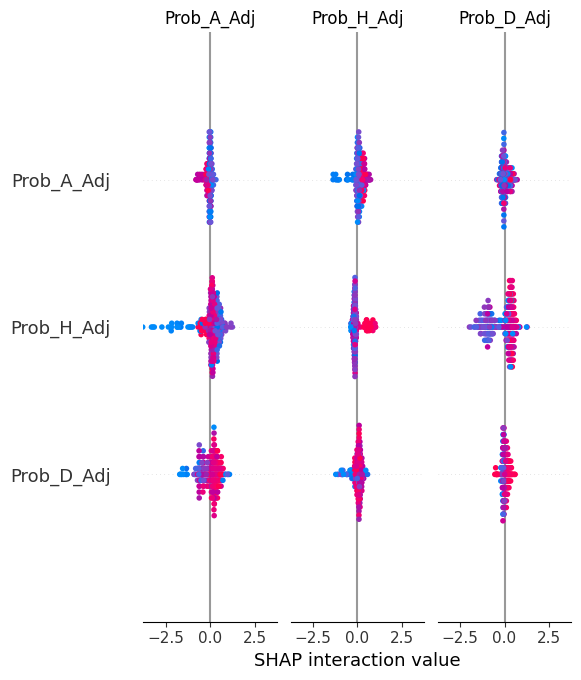


🚀 Iniciando o treinamento do Stack (Walk-Forward) com 3 features selecionadas...

Treinando modelos base finais com os dados completos e features selecionadas...
✅ STACK1x2 pronto: | bases: ['NB', 'LGBM', 'MLP', 'CAT', 'XGB']


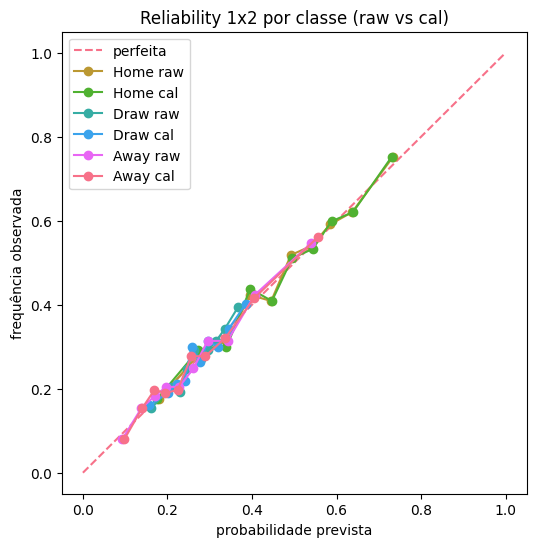

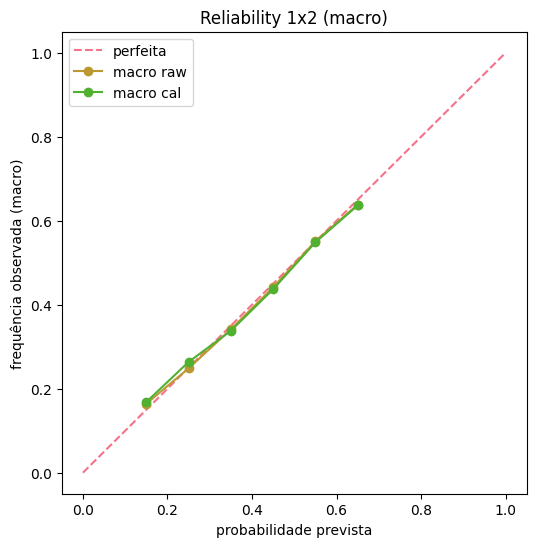


DESEMPENHO NO HOLDOUT (últimos 10%):
RAW: {'LogLoss': 0.9874987464494148, 'Brier': 0.5913309484826811}
CAL: {'LogLoss': 0.9907708150692724, 'Brier': 0.593286555288448}
n_test: 137


In [ ]:
# =========================================================================================
# RUNNER FINAL: PREPARAÇÃO COMPLETA -> SELEÇÃO SHAP -> TREINO -> VALIDAÇÃO
# =========================================================================================

# --- PASSO 1: PREPARAR O DATAFRAME COM TODAS AS FEATURES POSSÍVEIS ---

# Garante que as variáveis de etapas anteriores existem
assert 'dados_historicos_com_momentum' in globals(), "Execute a célula que cria as features de momentum primeiro!"
assert 'dixon_coles_model' in globals(), "O modelo Dixon-Coles não foi treinado. Execute a célula de treino do DC."

# 1.1 - Adiciona features de odds e garante a ordenação por data
dataframe_para_modelo = preparar_features_para_walk_forward(dados_historicos_com_momentum)

# 1.2 - Garante que a coluna alvo (target) existe
dataframe_para_modelo = garantir_target_1x2(dataframe_para_modelo)

# 1.3 - Adiciona as probabilidades do Dixon-Coles como features
print("\n🤖 Adicionando features do Dixon-Coles...")
probabilidades_dc = _dc_probs_1x2_em_lote(dataframe_para_modelo, dixon_coles_model)
dataframe_para_modelo[['p_H_DC', 'p_D_DC', 'p_A_DC']] = probabilidades_dc

# ######################################################################################
# --- NOVO PASSO: CALCULAR E ADICIONAR O XG IMPLÍCITO AVANÇADO ---
# ######################################################################################
print("\n🧮 Adicionando features de xG Implícito do Mercado...")
dataframe_final_para_modelo = calcular_xg_implicito(dataframe_para_modelo)
# ######################################################################################

print("\n=== DATAFRAME COM TODAS AS FEATURES PRONTO ===")
print("📊 Shape final das features:", dataframe_final_para_modelo.shape)


# --- PASSO 2: CRIAR A LISTA MESTRA COM TODAS AS FEATURES DISPONÍVEIS ---
print("\n⚙️  Criando a lista mestra de features para a análise SHAP...")

LISTA_DE_FEATURES_BASE_COMPLETA = [
    'Prob_H_Adj', 'Prob_D_Adj', 'Prob_A_Adj', 'Margem', 'Prob_1X', 'Prob_12', 'Prob_X2',
    'Prob_Over25', 'Prob_BTTS_Yes', 'Prob_H_fair', 'Prob_D_fair', 'Prob_A_fair',
    'Logit_H_fair', 'Logit_D_fair', 'Logit_A_fair',
    'p_H_DC', 'p_D_DC', 'p_A_DC',
    'Home_xG_Implied', 'Away_xG_Implied' # Novas features de xG
]
lista_de_features_momentum_completa = [coluna for coluna in dataframe_final_para_modelo.columns if 'Media_' in coluna]
LISTA_DE_FEATURES_TUDO = LISTA_DE_FEATURES_BASE_COMPLETA + lista_de_features_momentum_completa
# Garante que não há colunas duplicadas ou que não existem no DataFrame
LISTA_DE_FEATURES_TUDO = [col for col in list(dict.fromkeys(LISTA_DE_FEATURES_TUDO)) if col in dataframe_final_para_modelo.columns]


# --- PASSO 3: SELECIONAR AS MELHORES FEATURES COM SHAP ---
# (Esta etapa assume que a célula com a função selecionar_features_com_shap já foi executada)
LISTA_DE_FEATURES_SHAP = selecionar_features_com_shap(
    dataframe_final_para_modelo,
    LISTA_DE_FEATURES_TUDO,
    TARGET_1X2,
    k=20  # Número de features de elite que queremos selecionar
)


# --- PASSO 4: EXECUTAR O TREINO DO STACK USANDO APENAS AS FEATURES DE ELITE ---
oof_pack_1x2 = treinar_stack_1x2_dirichlet(
    dataframe_com_features=dataframe_final_para_modelo,
    lista_de_features_selecionadas=LISTA_DE_FEATURES_SHAP, # Usando a lista final do SHAP
    coluna_alvo=TARGET_1X2,
    numero_de_splits=5
)


# --- PASSO 5: AVALIAR OS RESULTADOS ---
plot_reliability_1x2(oof_pack_1x2, n_bins=10)

res_hold = avaliar_holdout_1x2(
    df_feat=dataframe_final_para_modelo,
    features=LISTA_DE_FEATURES_SHAP, # Usando a lista final do SHAP
    alvo_col=TARGET_1X2,
    holdout_frac=0.10
)

print("\nDESEMPENHO NO HOLDOUT (últimos 10%):")
print("RAW:", res_hold["raw"])
print("CAL:", res_hold["cal"])
print("n_test:", res_hold["n_test"])

In [ ]:
# ==========================================
# Tuning de α por bucket (por classe H/D/A), via OOF
# ==========================================
import numpy as np
from sklearn.metrics import brier_score_loss

# buckets padrão (fechados na esquerda, abertos na direita)
BUCKETS_1X2 = [(1.20,1.60),(1.60,2.00),(2.00,2.50),(2.50,3.20),(3.20,100.0)]
ALPHA_GRID  = (0.25, 0.50, 0.75, 1.00)

def _bucket_of(odd: float, buckets=BUCKETS_1X2):
    for lo, hi in buckets:
        if lo <= odd < hi:
            return (lo,hi)
    return buckets[-1]

def tune_alpha_buckets_1x2(P_raw_oof: np.ndarray,
                           P_cal_oof: np.ndarray,
                           df_feat: pd.DataFrame,
                           y_oof: np.ndarray,
                           buckets=BUCKETS_1X2,
                           alpha_grid=ALPHA_GRID):
    """
    Para cada classe k∈{Home,Draw,Away}, e para cada bucket de odds daquela classe,
    escolhe α∈{0.25,0.50,0.75,1.00} que minimiza o Brier 1-vs-all em OOF.
    Retorna dict: {'H':{bucket:alpha}, 'D':{...}, 'A':{...}} e salva em globals().
    """
    odds = df_feat[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).values
    out = {"H":{}, "D":{}, "A":{}}
    for k, label in enumerate(["H","D","A"]):
        odds_k = odds[:,k]
        for b in buckets:
            mask = (odds_k >= b[0]) & (odds_k < b[1])
            if not np.any(mask):
                out[label][b] = 0.75
                continue
            y_bin = (y_oof == k).astype(int)[mask]
            pr    = P_raw_oof[mask, k]
            pc    = P_cal_oof[mask, k]
            best = (1e9, 0.75)
            for a in alpha_grid:
                p = np.clip(a*pc + (1-a)*pr, 1e-9, 1-1e-9)
                brier = brier_score_loss(y_bin, p)
                if brier < best[0]:
                    best = (brier, a)
            out[label][b] = float(best[1])
    globals()["ALPHA_BUCKETS_1X2"] = out
    return out

# ===== Execute o tuning agora =====
assert "oof_pack_1x2" in globals(), "Rode o treinar_stack_1x2_dirichlet antes."
ALPHA_BUCKETS_1X2 = tune_alpha_buckets_1x2(
    oof_pack_1x2["P_raw_oof"],
    oof_pack_1x2["P_cal_oof"],
    dataframe_final_para_modelo,
    oof_pack_1x2["y"],
    buckets=BUCKETS_1X2,
    alpha_grid=ALPHA_GRID
)
print("ALPHA_BUCKETS_1X2:")
for cls in ["H","D","A"]:
    print(cls, {f"{lo:.2f}-{hi:.2f}": a for (lo,hi),a in ALPHA_BUCKETS_1X2[cls].items()})


ALPHA_BUCKETS_1X2:
H {'1.20-1.60': 1.0, '1.60-2.00': 0.25, '2.00-2.50': 1.0, '2.50-3.20': 1.0, '3.20-100.00': 1.0}
D {'1.20-1.60': 0.75, '1.60-2.00': 0.75, '2.00-2.50': 0.75, '2.50-3.20': 1.0, '3.20-100.00': 0.75}
A {'1.20-1.60': 0.25, '1.60-2.00': 1.0, '2.00-2.50': 1.0, '2.50-3.20': 0.75, '3.20-100.00': 1.0}


In [ ]:
# ==========================================
# SISTEMA APOSTAS 1x2 (prever_1x2 + aplicar_kelly_1x2)
# ==========================================
def _entropy(P_row: np.ndarray) -> float:
    """Entropia normalizada 0..1 (maior = mais incerteza)."""
    P = np.clip(np.asarray(P_row, float), 1e-12, 1-1e-12)
    H = -np.sum(P * np.log(P))
    Hmax = np.log(len(P))
    return float(H / Hmax)

def kelly_adaptativo(p: float, odd: float,
                     kelly_base: float = 0.25,
                     drawdown: float = 0.0, dd_cap: float = 0.30,
                     entropy01: float = 0.5, ent_weight: float = 0.35) -> float:
    """
    Kelly para aposta em UM outcome (ML) com shrink por drawdown e entropia:
    f = (b*p - q)/b ; b = odd-1 ; q = 1-p.
    """
    p = float(np.clip(p, 1e-9, 1-1e-9)); b = float(odd - 1.0); q = 1.0 - p
    if b <= 0: return 0.0
    f = (b*p - q) / b
    f = max(0.0, f)
    # shrink por entropia (mais incerteza => menor stake)
    ent_shrink = max(0.0, 1.0 - ent_weight*float(np.clip(entropy01, 0.0, 1.0)))
    # shrink por drawdown (0..dd_cap)
    dd_shrink  = max(0.0, 1.0 - min(max(drawdown,0.0), dd_cap)/dd_cap)
    return float(kelly_base * f * ent_shrink * dd_shrink)

# Buckets e gates (por outcome)
BUCKETS = [(1.20,1.60),(1.60,2.00),(2.00,2.50),(2.50,3.20),(3.20,100.0)]
def _bucket_of(odd: float, buckets=BUCKETS):
    for lo, hi in buckets:
        if lo <= odd < hi:
            return (lo,hi)
    return buckets[-1]

# Alpha por bucket (blend cal/raw do stack) — default
ALPHA_BUCKETS = {b: 0.75 for b in BUCKETS}

# Gates por outcome (odds liberadas e mínimos de EV/Edge)
GATES_BUCKETS = {
    # Exigimos um EV e Edge muito maiores para apostar em "Casa"
    "H": {b: {"MIN_EV":0.08, "EDGE_MIN":0.05, "ODD_MIN":2.01, "ODD_MAX":3.20} for b in BUCKETS},

    # Mantemos os critérios para Empate e Fora, que são os lucrativos
    "D": {b: {"MIN_EV":0.03, "EDGE_MIN":0.02, "ODD_MIN":2.80, "ODD_MAX":4.50} for b in BUCKETS},
    "A": {b: {"MIN_EV":0.03, "EDGE_MIN":0.02, "ODD_MIN":1.70, "ODD_MAX":3.50} for b in BUCKETS},
}

STAKE_CAP = 0.02   # 2% da banca (teto)


In [ ]:
# =================================================================================
# CLASSE DO SISTEMA DE APOSTAS (VERSÃO ATUALIZADA)
# =================================================================================

class SistemaApostas1x2:
    def __init__(self,
                 *,
                 consenso_std: float = 0.12,
                 consenso_min_models: int = 3):
        # Pega objetos globais treinados
        assert 'STACK1x2_META' in globals() and 'STACK1x2_CAL' in globals(), "Treine o stack 1x2 antes."
        assert 'STACK1x2_SCALER' in globals() and 'BASES_1x2' in globals(), "Bases/Scaler não encontrados."

        self.meta   = globals()['STACK1x2_META']
        self.cal    = globals()['STACK1x2_CAL']
        self.scaler = globals()['STACK1x2_SCALER']
        self.bases  = globals()['BASES_1x2']

        # ##########################################################################
        # ALTERAÇÃO AQUI: Substituímos 'FEATURES_PADRAO' pela nossa nova lista
        self.cols   = globals().get('STACK1x2_COLS', globals().get('LISTA_DE_FEATURES_TUDO', []))
        # ##########################################################################

        self.consenso_std = float(consenso_std)
        self.consenso_min_models = int(consenso_min_models)

    def prever_1x2(self, df_dia: pd.DataFrame) -> pd.DataFrame:
        df = df_dia.copy().reset_index(drop=True)
        assert all(c in df.columns for c in ["Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT"]), \
            "Faltam colunas básicas (Home/Away/odds)."

        Z, P_mkt = montar_Z_1x2(df)

        meta = globals()["STACK1x2_META"]
        P_raw = np.clip(meta.predict_proba(Z), 1e-9, 1-1e-9)

        cal = globals().get("STACK1x2_CAL", None)
        P_cal = np.clip(cal.transform(P_raw), 1e-9, 1-1e-9) if cal is not None else P_raw

        odds = df[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).values
        ALPHA = globals().get("ALPHA_BUCKETS_1X2", None)
        BUCKS = globals().get("BUCKETS_1X2", [(1.20,1.60),(1.60,2.00),(2.00,2.50),(2.50,3.20),(3.20,100.0)])

        P_final = np.zeros_like(P_raw)
        aH_list, aD_list, aA_list = [], [], []
        for i in range(len(df)):
            if ALPHA:
                bH = next((b for b in BUCKS if b[0] <= odds[i,0] < b[1]), BUCKS[-1])
                bD = next((b for b in BUCKS if b[0] <= odds[i,1] < b[1]), BUCKS[-1])
                bA = next((b for b in BUCKS if b[0] <= odds[i,2] < b[1]), BUCKS[-1])
                aH = ALPHA.get("H", {}).get(bH, 0.75)
                aD = ALPHA.get("D", {}).get(bD, 0.75)
                aA = ALPHA.get("A", {}).get(bA, 0.75)
            else:
                aH = aD = aA = 0.75

            Pf = np.empty(3, float)
            Pf[0] = aH*P_cal[i,0] + (1-aH)*P_raw[i,0]
            Pf[1] = aD*P_cal[i,1] + (1-aD)*P_raw[i,1]
            Pf[2] = aA*P_cal[i,2] + (1-aA)*P_raw[i,2]
            s = Pf.sum()
            P_final[i,:] = Pf/s if s>0 else np.array([1/3,1/3,1/3])
            aH_list.append(float(aH)); aD_list.append(float(aD)); aA_list.append(float(aA))

        out = df.copy()
        out[["P_H","P_D","P_A"]]       = P_final
        out[["MKT_H","MKT_D","MKT_A"]] = P_mkt
        out["alpha_H"] = aH_list
        out["alpha_D"] = aD_list
        out["alpha_A"] = aA_list

        try:
            order = globals().get("STACK1x2_ORDER", ["MKT_LOG","DC"])
            meta = globals()["STACK1x2_META"]
            start = 0
            blocks = {}
            for key in order[: int(getattr(meta, 'n_features_in_', 0)//3) ]:
                # Usamos Z, que tem as previsões brutas dos modelos base
                Z_para_std = meta.predict_log_proba(Z) # Um proxy para as ativações brutas
                blocks[key] = Z_para_std[:, start:start+3]
                start += 3
            pstd = []
            for i in range(len(df)):
                k = int(np.argmax(P_final[i]))
                bag = [blocks[key][i,k] for key in blocks]
                pstd.append(float(np.std(bag, ddof=0)))
            out["p_std"] = pstd
            out["consenso_ok"] = [ps <= self.consenso_std for ps in pstd]
            out["consenso_base"] = "1x2"
        except Exception as e:
            out["p_std"] = 0.0
            out["consenso_ok"] = True
            out["consenso_base"] = "1x2_fallback"
        return out

    def aplicar_kelly_1x2(self, df_pred: pd.DataFrame, *, banca_inicial: float) -> pd.DataFrame:
        df = df_pred.copy()
        odds = df[["Odd_H_FT","Odd_D_FT","Odd_A_FT"]].astype(float).values
        P    = df[["P_H","P_D","P_A"]].astype(float).values
        MKT  = df[["MKT_H","MKT_D","MKT_A"]].astype(float).values

        jogos = []
        for i in range(len(df)):
            linhas = []
            tags_outcome = ["H","D","A"]
            nomes_lado   = ["Casa ML", "Empate", "Fora ML"]
            for k in range(3):
                p = float(P[i,k]); odd = float(odds[i,k]); pmkt = float(MKT[i,k])
                EV   = p*odd - 1.0
                EDGE = p - pmkt
                bkt  = _bucket_of(odd)
                gates = GATES_BUCKETS[tags_outcome[k]].get(bkt, {"MIN_EV":0.03,"EDGE_MIN":0.00,"ODD_MIN":1.50,"ODD_MAX":100.0})
                ent  = _entropy(P[i,:])
                frac = kelly_adaptativo(p, odd, kelly_base=0.25,
                                        drawdown=DRAWDOWN_ATUAL, dd_cap=DD_CAP,
                                        entropy01=ent, ent_weight=0.35)
                stake_pct = min(frac, STAKE_CAP)
                stake_val = round(float(stake_pct * banca_inicial), 2)

                ok = (EV >= gates["MIN_EV"]) and (EDGE >= gates["EDGE_MIN"]) \
                     and (gates["ODD_MIN"] <= odd <= gates["ODD_MAX"]) \
                     and bool(df.at[i,"consenso_ok"]) and (stake_val > 0)

                motivo = ("OK (EV %.3f, Edge %.3f, odd %.2f, α=%.2f, std=%.3f)"
                          % (EV, EDGE, odd, df.at[i,"alpha_bucket"], df.at[i,"p_std"])) if ok \
                        else ("Negado: EV<%.2f ou Edge<%.2f ou odd fora [%.2f,%.2f] ou consenso/std reprov."
                              % (gates["MIN_EV"], gates["EDGE_MIN"], gates["ODD_MIN"], gates["ODD_MAX"]))

                linhas.append({
                    "lado": nomes_lado[k], "p": p, "odd": odd, "EV": EV, "Edge": EDGE,
                    "stake_pct": stake_pct, "stake_val": stake_val, "bucket": bkt,
                    "motivo": motivo, "ok": ok
                })

            aprovadas = [ln for ln in linhas if ln["ok"]]
            if aprovadas:
                r = max(aprovadas, key=lambda t: t['EV'])
                apostar = True
                motivo_final = r['motivo']
            else:
                r = max(linhas, key=lambda t: t['EV'])
                apostar = False
                motivo_final = r['motivo']

            jogos.append({
                "jogo": f"{df.at[i,'Home']} vs {df.at[i,'Away']} — {r['lado']}",
                "Tipo_Aposta": r["lado"],
                "p": r["p"],
                "odd": r["odd"],
                "EV": r["EV"],
                "Edge": r["Edge"],
                "valor_apostar": r["stake_val"],
                "pct_banca": r["stake_pct"],
                "alpha_bucket": df.at[i,"alpha_bucket"],
                "p_std": df.at[i,"p_std"],
                "apostar?": apostar,
                "motivo": motivo_final
            })

        out = pd.DataFrame(jogos).sort_values("EV", ascending=False).reset_index(drop=True)
        def _fmt_brl(v): return f"R$ {v:,.2f}".replace(",", "X").replace(".", ",").replace("X",".")
        out["valor_apostar_fmt"] = out["valor_apostar"].apply(_fmt_brl)
        cols = ["jogo","odd","p","EV","Edge","valor_apostar_fmt","valor_apostar","pct_banca",
                "Tipo_Aposta","apostar?","motivo"]
        return out[cols]

In [ ]:
# =================================================================================
# EXEMPLO — PREVISÃO DO DIA + KELLY (1 decisão por jogo)
# VERSÃO FINAL CORRIGIDA
# =================================================================================

# Garantimos que as variáveis necessárias existem
assert 'jogos_do_dia_com_momentum' in globals(), "Execute a célula de preparação dos dados primeiro!"
assert 'dixon_coles_model' in globals(), "O modelo Dixon-Coles não foi treinado. Execute a célula de treino do DC."

# --- PASSO 1: PREPARAR DATAFRAME BASE PARA PREVISÃO ---
dataframe_para_previsao = jogos_do_dia_com_momentum.copy()
mapa_de_nomes = {
    'Liga':'League','Casa':'Home','Fora':'Away',
    'Odd_Casa':'Odd_H_FT','Odd_Empate':'Odd_D_FT','Odd_Fora':'Odd_A_FT',
    'Odd_H':'Odd_H_FT','Odd_D':'Odd_D_FT','Odd_A':'Odd_A_FT',
    'Odd_1':'Odd_H_FT','Odd_X':'Odd_D_FT','Odd_2':'Odd_A_FT'
}
for nome_antigo, nome_novo in mapa_de_nomes.items():
    if nome_antigo in dataframe_para_previsao.columns and nome_novo not in dataframe_para_previsao.columns:
        dataframe_para_previsao = dataframe_para_previsao.rename(columns={nome_antigo: nome_novo})

dataframe_pronto_para_previsao = criar_features_basicas(dataframe_para_previsao)


# ######################################################################################
# --- PASSO 1.5: ADICIONAR FEATURES DO DIXON-COLES (A CORREÇÃO ESTÁ AQUI) ---
print("\n🤖 Adicionando features do Dixon-Coles aos jogos do dia...")
probabilidades_dc_dia = _dc_probs_1x2_em_lote(dataframe_pronto_para_previsao, dixon_coles_model)
dataframe_pronto_para_previsao[['p_H_DC', 'p_D_DC', 'p_A_DC']] = probabilidades_dc_dia
# ######################################################################################


print("\n✅ DataFrame para previsão pronto, contendo todas as features (odds, momentum e DC).")


# --- PASSO 2: EXECUTAR A PREVISÃO E A ESTRATÉGIA KELLY ---
sistema_de_apostas = SistemaApostas1x2(consenso_std=0.12, consenso_min_models=3)
dataframe_com_previsoes = sistema_de_apostas.prever_1x2(dataframe_pronto_para_previsao)

if "alpha_bucket" not in dataframe_com_previsoes.columns:
    dataframe_com_previsoes["alpha_bucket"] = dataframe_com_previsoes["alpha_H"] if "alpha_H" in dataframe_com_previsoes.columns else 0.75

=== CRIANDO FEATURES PARA MACHINE LEARNING ===
📊 Detectados dados históricos (FT)
✅ Features criadas. Shape: (6, 86)

🤖 Adicionando features do Dixon-Coles aos jogos do dia...

✅ DataFrame para previsão pronto, contendo todas as features (odds, momentum e DC).


In [ ]:
# --- PASSO 3: AUDITORIA E SUGESTÕES ---
print("\n🧾 AUDIT — Jogos do dia (P_H/P_D/P_A, MKT e alpha por bucket)")
colunas_de_auditoria = [
    "League","Home","Away","Odd_H_FT","Odd_D_FT","Odd_A_FT",
    "P_H","P_D","P_A","MKT_H","MKT_D","MKT_A",
    "alpha_H","alpha_D","alpha_A",
    "p_std","consenso_ok","consenso_base"
]

colunas_de_auditoria = [coluna for coluna in colunas_de_auditoria if coluna in dataframe_com_previsoes.columns]
display(dataframe_com_previsoes[colunas_de_auditoria])


🧾 AUDIT — Jogos do dia (P_H/P_D/P_A, MKT e alpha por bucket)


,League,Home,Away,Odd_H_FT,Odd_D_FT,Odd_A_FT,P_H,P_D,P_A,MKT_H,MKT_D,MKT_A,alpha_H,alpha_D,alpha_A,p_std,consenso_ok,consenso_base
0,BRAZIL 1,Sport Recife,Fluminense,3.20,3.1,2.40,0.234255,0.365059,0.400686,0.297125,0.306709,0.396166,1.00,1.00,1.0,0.0,True,1x2_fallback
1,BRAZIL 1,Palmeiras,Vasco,1.36,5.0,8.50,0.735656,0.171535,0.092809,0.698324,0.189944,0.111732,1.00,0.75,1.0,0.0,True,1x2_fallback
2,BRAZIL 1,Mirassol,Bragantino,1.91,3.3,4.33,0.619696,0.227874,0.152429,0.495075,0.286543,0.218382,0.25,0.75,1.0,0.0,True,1x2_fallback
3,BRAZIL 1,Internacional,Corinthians,2.05,3.2,4.00,0.480964,0.278957,0.240080,0.464441,0.297533,0.238026,1.00,0.75,1.0,0.0,True,1x2_fallback
4,BRAZIL 1,Santos,Gremio,2.05,3.4,3.70,0.459619,0.298255,0.242126,0.463608,0.279528,0.256864,1.00,0.75,1.0,0.0,True,1x2_fallback
5,BRAZIL 1,Botafogo RJ,Bahia,1.80,3.5,4.50,0.582383,0.218677,0.198940,0.522388,0.268657,0.208955,0.25,0.75,1.0,0.0,True,1x2_fallback


In [ ]:
banca_inicial = globals().get("BANCA_INICIAL", 100.0)
sugestoes_de_aposta = sistema_de_apostas.aplicar_kelly_1x2(dataframe_com_previsoes, banca_inicial=banca_inicial)

print("\n✅ SUGESTÕES (EV + Kelly adaptativo; 1 decisão por jogo; com motivo):")
display(sugestoes_de_aposta)


✅ SUGESTÕES (EV + Kelly adaptativo; 1 decisão por jogo; com motivo):


,jogo,odd,p,EV,Edge,valor_apostar_fmt,valor_apostar,pct_banca,Tipo_Aposta,apostar?,motivo
0,Mirassol vs Bragantino — Casa ML,1.91,0.619696,0.183620,0.124622,"R$ 2,00",2.00,0.020000,Casa ML,False,Negado: EV<0.08 ou Edge<0.05 ou odd fora [2.01...
1,Sport Recife vs Fluminense — Empate,3.10,0.365059,0.131683,0.058350,"R$ 1,03",1.03,0.010311,Empate,True,"OK (EV 0.132, Edge 0.058, odd 3.10, α=1.00, st..."
2,Botafogo RJ vs Bahia — Casa ML,1.80,0.582383,0.048289,0.059995,"R$ 1,04",1.04,0.010434,Casa ML,False,Negado: EV<0.08 ou Edge<0.05 ou odd fora [2.01...
3,Santos vs Gremio — Empate,3.40,0.298255,0.014066,0.018726,"R$ 0,10",0.10,0.000970,Empate,False,Negado: EV<0.03 ou Edge<0.02 ou odd fora [2.80...
4,Palmeiras vs Vasco — Casa ML,1.36,0.735656,0.000492,0.037332,"R$ 0,03",0.03,0.000260,Casa ML,False,Negado: EV<0.08 ou Edge<0.05 ou odd fora [2.01...
5,Internacional vs Corinthians — Casa ML,2.05,0.480964,-0.014024,0.016523,"R$ 0,00",0.00,0.000000,Casa ML,False,Negado: EV<0.08 ou Edge<0.05 ou odd fora [2.01...


### 1. Probabilidades do Mercado (`MKT_H`, `MKT_D`, `MKT_A`)

Estas colunas representam a visão do mercado de apostas, ou seja, a "opinião da multidão".

* **`MKT_H` (Market Home)**
    * **O que é?** É a probabilidade "justa" da vitória do time da **Casa**, calculada a partir das odds depois de remover a margem de lucro da casa de apostas.
    * **Para que serve?** É o seu ponto de referência. O sistema compara a probabilidade que o *seu modelo* calculou (`P_H`) com a do mercado (`MKT_H`). A diferença entre elas (`P_H - MKT_H`) é o que gera o **"Edge"** (a vantagem). Se o seu modelo acha que a chance é de 55% (`P_H = 0.55`) e o mercado acha que é 50% (`MKT_H = 0.50`), você tem um Edge positivo de 5%.

* **`MKT_D` (Market Draw)**
    * **O que é?** A mesma coisa, mas para o **Empate**.

* **`MKT_A` (Market Away)**
    * **O que é?** A mesma coisa, mas para a vitória do time **Fora**.

---

### 2. Parâmetros de Mistura (`alpha_H`, `alpha_D`, `alpha_A`)

Essas colunas controlam a "receita" da sua probabilidade final, misturando duas versões da previsão do seu modelo.

* **`alpha_H` (Alpha Home)**
    * **O que é?** É um fator de ponderação (entre 0 e 1) usado para misturar a probabilidade **bruta** (`P_raw`) com a probabilidade **calibrada** (`P_cal`) para o resultado "Casa". A sua probabilidade final é calculada assim: `P_final = alpha * P_cal + (1 - alpha) * P_raw`.
    * **Para que serve?** É um ajuste fino. Seu código inteligentemente define um `alpha` diferente para cada faixa de odd, pois descobriu (na fase de tuning) que para certas odds, uma mistura específica funciona melhor do que usar apenas a probabilidade 100% calibrada. Um `alpha_H` de `0.75` significa que a previsão final para a vitória da casa usou 75% da versão calibrada e 25% da versão bruta.

* **`alpha_D` (Alpha Draw)**
    * **O que é?** O mesmo fator de mistura, mas aplicado à probabilidade de **Empate**.

* **`alpha_A` (Alpha Away)**
    * **O que é?** O mesmo fator de mistura, mas aplicado à probabilidade de vitória do time **Fora**.

---

### 3. Métricas de Consenso do Modelo (`p_std`, `consenso_ok`, `consenso_base`)

Estas colunas medem o grau de **acordo** entre os diferentes modelos que compõem o seu sistema. Elas funcionam como um importante controle de risco.

* **`p_std` (Probability Standard Deviation)**
    * **O que é?** É o desvio padrão entre as previsões dos seus modelos base (XGBoost, CatBoost, Dixon-Coles, etc.) para o resultado mais provável.
    * **Para que serve?** Mede a confiança do ensemble.
        * **`p_std` baixo:** Os modelos concordam entre si. A previsão é mais confiável.
        * **`p_std` alto:** Os modelos discordam. A previsão é incerta e arriscada.

* **`consenso_ok`**
    * **O que é?** Uma simples bandeira `True` ou `False`.
    * **Para que serve?** É um portão de segurança. Ela será `True` apenas se o `p_std` for menor que um limite que você definiu (ex: `0.12`). Se for `False`, o sistema pode ser programado para **não apostar** naquele jogo, mesmo que o EV pareça bom, porque os especialistas (seus modelos) estão em forte desacordo.

* **`consenso_base`**
    * **O que é?** Uma coluna de texto que informa qual método ou grupo de modelos foi usado para calcular o consenso.
    * **Para que serve?** É um registro para diagnóstico. No seu sistema final (`SistemaApostas1x2`), ele provavelmente mostrará sempre `"1x2"`, indicando que o consenso foi calculado entre os modelos que compõem o stack final para o mercado de Resultado Final.

In [ ]:
# =================================================================================
# CÉLULA EXTRA: CÁLCULO DE ROI NO CONJUNTO DE HOLDOUT COM CRITÉRIO DE KELLY (CORREÇÃO FINAL)
# =================================================================================
import matplotlib.pyplot as plt
import numpy as np

def calcular_roi_holdout_kelly(dataframe_final, sistema_apostas, banca_inicial=100.0, holdout_frac=0.10):
    """
    Calcula o ROI em um conjunto de holdout usando a estratégia de aposta com Critério de Kelly.
    Também plota a evolução da banca ao longo do tempo.
    """
    print(f"\n\n--- Iniciando Simulação de ROI no Holdout (Critério de Kelly, Banca Inicial de R$ {banca_inicial:.2f}) ---")

    # --- PASSO 1: ISOLAR OS DADOS DE HOLDOUT ---
    tamanho_dataframe = len(dataframe_final)
    tamanho_holdout = max(1, int(round(holdout_frac * tamanho_dataframe)))
    df_holdout = dataframe_final.iloc[tamanho_dataframe - tamanho_holdout:].copy().reset_index(drop=True)
    print(f"📈 Usando um conjunto de holdout com {len(df_holdout)} jogos.")

    # --- PASSO 2: GERAR PREVISÕES E SUGESTÕES KELLY PARA O HOLDOUT ---
    df_pred_holdout = sistema_apostas.prever_1x2(df_holdout)

    if "alpha_bucket" not in df_pred_holdout.columns:
        df_pred_holdout["alpha_bucket"] = df_pred_holdout["alpha_H"] if "alpha_H" in df_pred_holdout.columns else 0.75

    sugestoes_holdout = sistema_apostas.aplicar_kelly_1x2(df_pred_holdout, banca_inicial=banca_inicial)

    apostas_a_fazer = sugestoes_holdout[sugestoes_holdout['apostar?'] == True].copy()

    if not apostas_a_fazer.empty:
        # ##########################################################################
        # ALTERAÇÃO AQUI: Corrigindo a extração dos nomes Home e Away
        apostas_a_fazer[['Home', 'Away']] = apostas_a_fazer['jogo'].str.split(' — ', expand=True)[0].str.split(' vs ', expand=True)
        # ##########################################################################
        apostas_com_resultados = pd.merge(apostas_a_fazer, df_holdout[['Home', 'Away', 'Resultado_1X2']], on=['Home', 'Away'], how='left')
    else:
        apostas_com_resultados = pd.DataFrame() # Cria um DF vazio se não houver apostas

    # --- PASSO 3: SIMULAR A EVOLUÇÃO DA BANCA ---
    banca_simulada = banca_inicial
    historico_banca = [banca_inicial]
    total_apostado = 0
    numero_de_apostas = len(apostas_com_resultados)

    mapa_tipo_aposta = {"Casa ML": 0, "Empate": 1, "Fora ML": 2}

    if numero_de_apostas > 0:
        for index, aposta in apostas_com_resultados.iterrows():
            stake = aposta['valor_apostar']
            stake = min(stake, banca_simulada)
            total_apostado += stake

            tipo_aposta_int = mapa_tipo_aposta.get(aposta['Tipo_Aposta'])
            resultado_real = aposta['Resultado_1X2']

            if tipo_aposta_int == resultado_real:
                lucro = stake * (aposta['odd'] - 1)
                banca_simulada += lucro
            else:
                banca_simulada -= stake

            historico_banca.append(banca_simulada)

            if banca_simulada <= 0:
                print("🚫 Banca quebrou!")
                break

    banca_final = banca_simulada
    lucro_total = banca_final - banca_inicial

    # --- PASSO 4: CALCULAR E EXIBIR O ROI ---
    if total_apostado > 0:
        roi = (lucro_total / total_apostado) * 100
    else:
        roi = 0

    print("\n--- Resultados da Simulação (Kelly) ---")
    print(f"Banca Inicial: R$ {banca_inicial:.2f}")
    print(f"Banca Final: R$ {banca_final:.2f}")
    print(f"Total de Apostas Realizadas: {numero_de_apostas}")
    print(f"Valor Total Apostado (Turnover): R$ {total_apostado:.2f}")
    print(f"Lucro/Prejuízo Total: R$ {lucro_total:.2f}")
    print(f"ROI (Retorno Sobre o Investimento): {roi:.2f}%")
    print("-----------------------------------------")

    # --- PASSO 5: PLOTAR O GRÁFICO DA EVOLUÇÃO DA BANCA ---
    if numero_de_apostas > 1:
        plt.figure(figsize=(10, 6))
        plt.plot(historico_banca, marker='o', linestyle='-', markersize=4)
        plt.title('Evolução da Banca no Período de Holdout (Critério de Kelly)')
        plt.xlabel('Número da Aposta')
        plt.ylabel('Valor da Banca (R$)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.axhline(y=banca_inicial, color='r', linestyle='--', label=f'Banca Inicial (R$ {banca_inicial:.2f})')
        plt.legend()
        plt.show()

# --- Execução da Análise de ROI com Kelly ---
assert 'dataframe_final_para_modelo' in globals(), "DataFrame final não encontrado."
assert 'sistema_de_apostas' in globals(), "O objeto 'sistema_de_apostas' não foi criado."

calcular_roi_holdout_kelly(
    dataframe_final=dataframe_final_para_modelo,
    sistema_apostas=sistema_de_apostas,
    banca_inicial=100.0,
    holdout_frac=0.10
)


## Colunas necessárias jogos do dia:

| id | League | Round | Date | Time | Home | Away | Odd_H_HT | Odd_D_HT | Odd_A_HT
| Odd_Over05_HT | Odd_Under05_HT | Odd_Over15_HT | Odd_Under15_HT | Odd_Over25_HT
| Odd_Under25_HT | Odd_H_FT | Odd_D_FT | Odd_A_FT | Odd_Over05_FT | Odd_Under05_FT
| Odd_Over15_FT | Odd_Under15_FT | Odd_Over25_FT | Odd_Under25_FT | Odd_Over35_FT | Odd_Under35_FT | Odd_Over45_FT
| Odd_Under45_FT | Odd_BTTS_Yes | Odd_BTTS_No | Odd_1X | Odd_12 | Odd_X2 | Odd_0x0 | Odd_0x1 | Odd_0x2 | Odd_0x3 | Odd_1x0
| Odd_1x1 | Odd_1x2 | Odd_1x3 | Odd_2x0 | Odd_2x1 | Odd_2x2 | Odd_2x3 | Odd_3x0 | Odd_3x1 | Odd_3x2 | Odd_3x3 | Odd_4x4 |


## Colunas dados históricos:
| Id | Date | Time | League | Season | Round | Home | Away | Odd_H_FT | Odd_D_FT | Odd_A_FT | Odd_Over05_FT
| Odd_Under05_FT | Odd_Over15_FT | Odd_Under15_FT | Odd_Over25_FT | Odd_Under25_FT | Odd_Over35_FT | Odd_Under35_FT
| Odd_Over45_FT | Odd_Under45_FT | Odd_H_HT | Odd_D_HT | Odd_A_HT | Odd_Over05_HT | Odd_Under05_HT | Odd_Over15_HT
| Odd_Under15_HT | Odd_Over25_HT | Odd_Under25_HT | Odd_1X_FT | Odd_12_FT | Odd_X2_FT | Odd_BTTS_Yes | Odd_BTTS_No
| Goals_H_HT | Goals_A_HT | Goals_H_FT | Goals_A_FT | Min_Goals_H | Min_Goals_A |